<IPython.core.display.Javascript object>


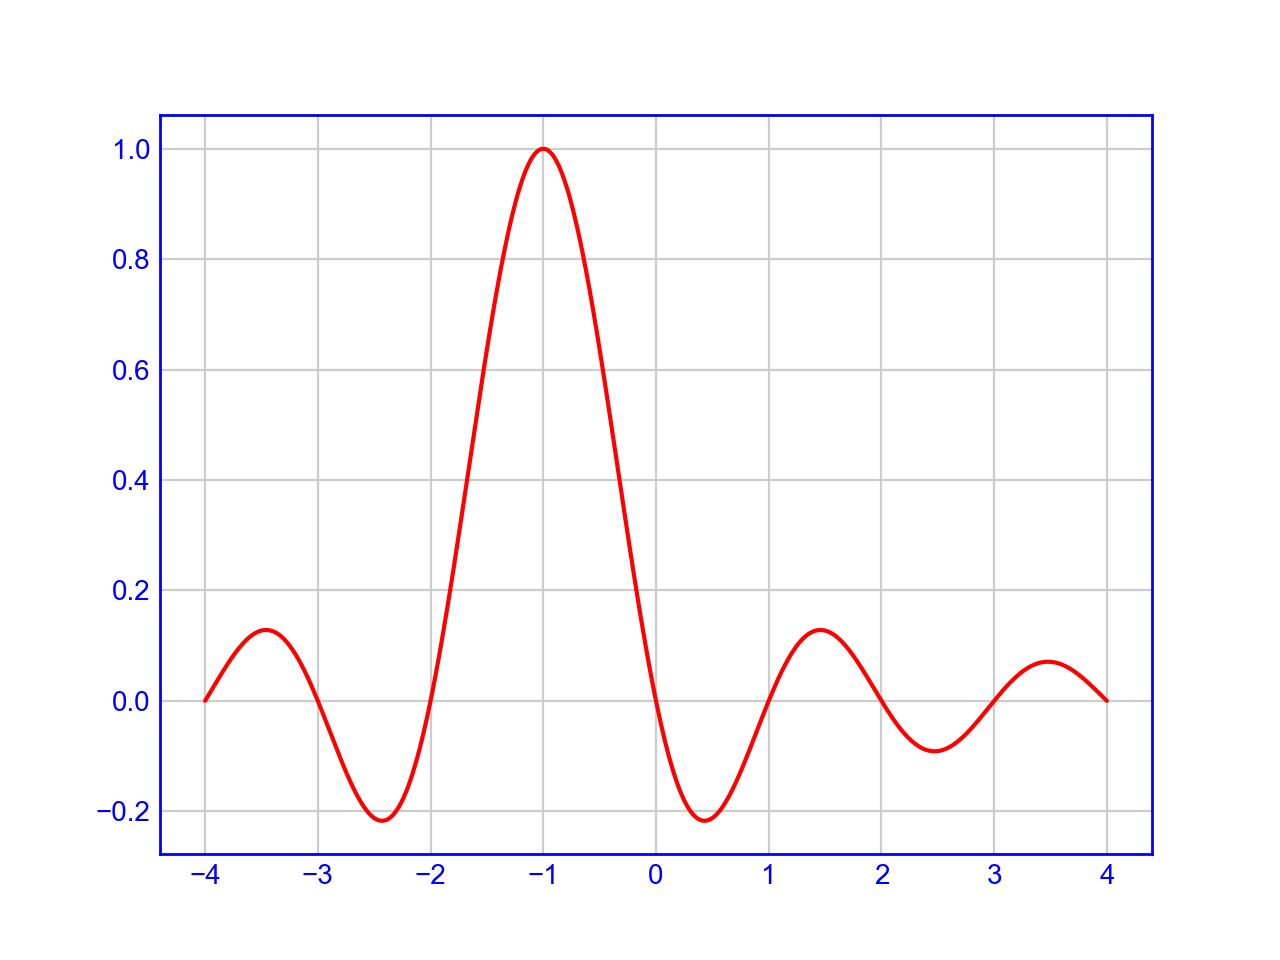

In [1]:
# coding: utf-8
get_ipython().magic(u'matplotlib notebook')
# %matplotlib notebook

import sys, math
import numpy as np
import scipy
import diy
from matplotlib import pyplot as plt

from scipy import linalg, matrix
from scipy.interpolate import LSQUnivariateSpline, UnivariateSpline, interp1d

plt.style.use(['seaborn-whitegrid'])
# plt.style.use(['ggplot'])
# plt.style.use(['classic'])
params = {"ytick.color" : "b",
          "xtick.color" : "b",
          "axes.labelcolor" : "b",
          "axes.edgecolor" : "b"}
plt.rcParams.update(params)

# --- set problem input parameters here ---
Dmin           = -4.
Dmax           = 4.
nPoints        = 480
nSubDomains    = 4
degree         = 3
overlap        = 0
sincFunc       = True
scale          = 1
# ------------------------------------------

if sincFunc:
    x = np.linspace(Dmin, Dmax, nPoints)
    y = scale * np.sinc(x+1)
    # y = scale * np.sin(math.pi * x/4)
else:
    y = np.fromfile("s3d.raw", dtype=np.float64) #
    nPoints = y.shape[0]
    x = np.linspace(Dmin, Dmax, nPoints)

if nPoints % nSubDomains > 0:
    print ( "[ERROR]: The total number of points do not divide equally with subdomains" )
    sys.exit(1)

mpl_fig = plt.figure()
plt.plot(x, y, 'r-', ms=2)

# Initialize DIY
w = diy.mpi.MPIComm()           # world


In [19]:
class BlockSimple:
    def __init__(self, core):
        self.core = core

    def show(self, cp):
        print(w.rank, cp.gid(), self.core)
        #cp.enqueue(diy.BlockID(1, 0), "abc")

    def send(self, cp):
        link = cp.link()
        for i in range(len(link)):
            target = link.target(i)
            o = [cp.gid(), target.gid]
            print("%d sending to %d: %s" % (cp.gid(), target.gid, o))
            cp.enqueue(target, o) 

    def recv(self, cp):
        link = cp.link()
        for i in range(len(link)):
            gid = link.target(i).gid
            o = cp.dequeue(gid)
            print("%d received from %d: %s" % (cp.gid(), gid, o))

def add_block_simple(gid, core, bounds, domain, link):
    #print(gid, core, bounds, domain)
    ms.add(gid, BlockSimple(core), link)

share_face = [True]
wrap = [True, False, False]
ghosts = [1,0,0]
# Initialize DIY
ms = diy.Master(w)               # master
domain_simple = diy.ContinuousBounds([min(x),min(y)], [max(x),max(y)])
d_simple = diy.ContinuousDecomposer(1, domain_simple, nSubDomains, share_face, wrap, ghosts)
a_simple = diy.ContiguousAssigner(w.size, nSubDomains)
d_simple.decompose(w.rank, a_simple, add_block_simple)

print (domain_simple)

ms.foreach(BlockSimple.show)
ms.foreach(BlockSimple.send)
ms.exchange(False)

ms.foreach(BlockSimple.recv)


[-4 -0.189207 - 4 1]
0 0 [-4 - 4]
0 sending to 0: [0, 0]
0 sending to 0: [0, 0]
0 received from 0: [0, 0]
0 received from 0: [0, 0]


Subdomain 0:  [0 - 120] [0 - 121] [0 - 479]
Subdomain 1:  [120 - 240] [119 - 241] [0 - 479]
Subdomain 2:  [240 - 360] [239 - 361] [0 - 479]
Subdomain 3:  [360 - 479] [359 - 479] [0 - 479]
Rank: 0, Subdomain 3: Bounds = [360,479]
Rank: 0, Subdomain 2: Bounds = [240,360]
Rank: 0, Subdomain 1: Bounds = [120,240]
Rank: 0, Subdomain 0: Bounds = [0,120]


<IPython.core.display.Javascript object>


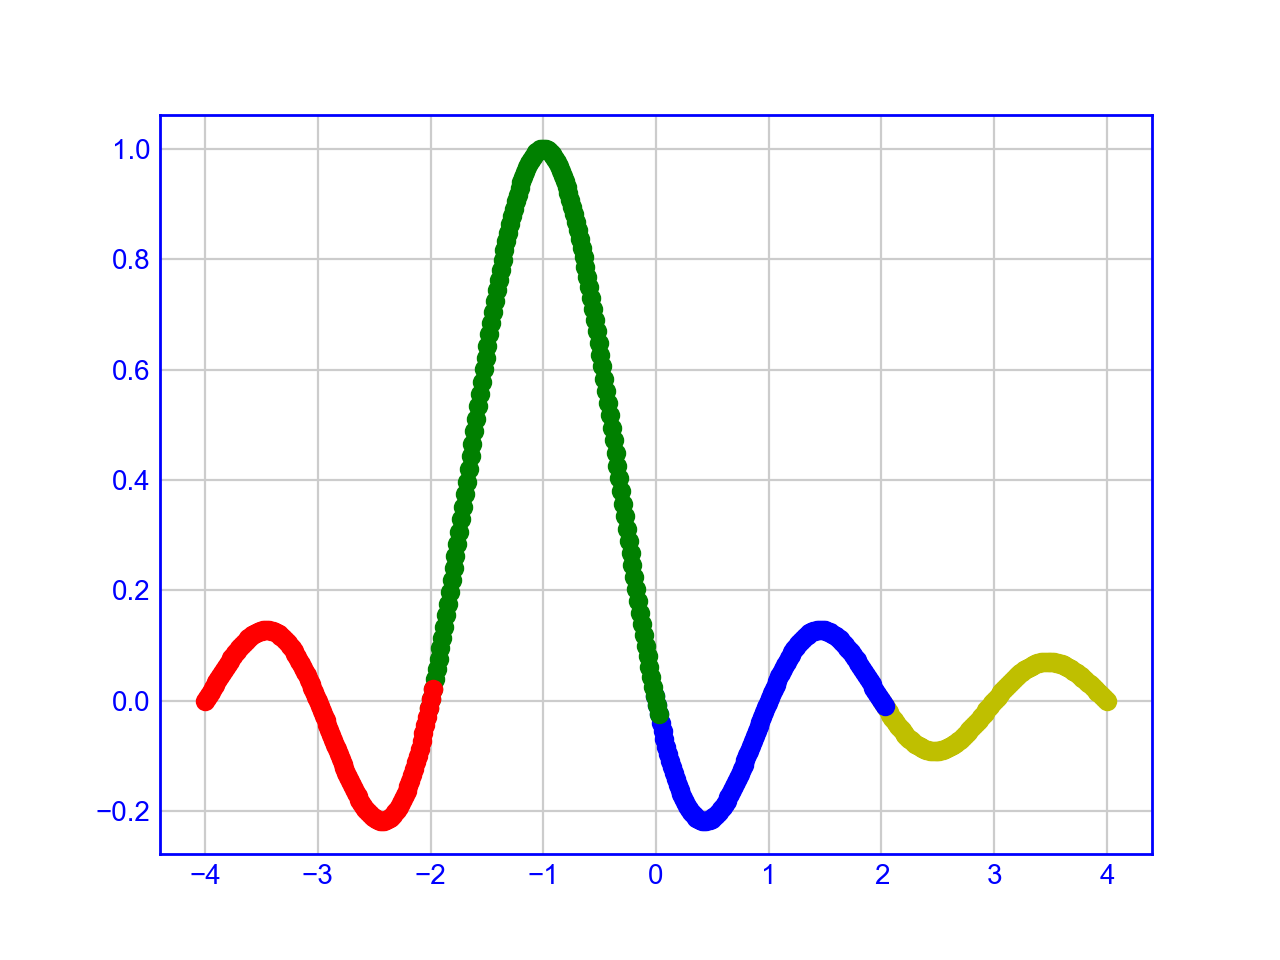

In [5]:
class InputBlock:

    def __init__(self, xb, xl, yl):
        self.xbounds = xb
        self.xl = xl
        self.yl = yl

    def show(self, cp):
        print("Rank: %d, Subdomain %d: Bounds = [%d,%d]" % (w.rank, cp.gid(), self.xbounds.min[0], self.xbounds.max[0]))
        #cp.enqueue(diy.BlockID(1, 0), "abc")

    def plot(self, cp):
#         print(w.rank, cp.gid(), self.core)
#         coeffs_x = getControlPoints(knotsAdaptive, degree) * (Dmax - Dmin) + Dmin
        if nSubDomains < 5:
            plt.plot(self.xl, self.yl, marker='o', linestyle='--', color=['r','g','b','y','c'][cp.gid()], label='Control')
        else:
            plt.plot(self.xl, self.yl, marker='o', label='Control')
        #cp.enqueue(diy.BlockID(1, 0), "abc")

    def send(self, cp):
        link = cp.link()
        for i in range(len(link)):
            target = link.target(i)
            o = [cp.gid(), target.gid]
            print("%d sending to %d: %s" % (cp.gid(), target.gid, o))
            cp.enqueue(target, o) 

    def recv(self, cp):
        link = cp.link()
        for i in range(len(link)):
            gid = link.target(i).gid
            o = cp.dequeue(gid)
            print("%d received from %d: %s" % (cp.gid(), gid, o))

def add_input_block(gid, core, bounds, domain, link):
    print("Subdomain %d: " % gid, core, bounds, domain)
    minb = bounds.min
    maxb = bounds.max
    xlocal = x[minb[0]:maxb[0]+1]
    ylocal = y[minb[0]:maxb[0]+1]
    mi.add(gid, InputBlock(core,xlocal,ylocal), link)

share_face = [True]
wrap = [False]
ghosts = [1]

# Initialize DIY
mi = diy.Master(w)         # master
domain_input = diy.DiscreteBounds([0], [len(x)-1])

# domain = diy.ContinuousBounds([min(x),min(y)], [max(x),max(y)])
# domain = diy.ContinuousBounds([x], [y])

d_input = diy.DiscreteDecomposer(1, domain_input, nSubDomains, share_face, wrap, ghosts)
a_input = diy.ContiguousAssigner(w.size, nSubDomains)
d_input.decompose(w.rank, a_input, add_input_block)

mi.foreach(InputBlock.show)

plt.figure()
if nSubDomains > 5:
    plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'c']) + cycler('linestyle', ['-','--',':','-.',''])))
plt.plot(x, y, 'b-', ms=5, label='Input')
mi.foreach(InputBlock.plot)

# Send receive data
# mi.foreach(Block.send)
# mi.exchange(False)
# mi.foreach(Block.recv)


In [20]:
from scipy.interpolate import Rbf

from scipy.optimize import minimize, linprog
from scipy.linalg import svd

from makruth_solver import getControlPoints, basis, decode, Error

def decode_derivative(P, W, x, t, degree):
    return np.array([(np.sum(basis(x[u],degree,t) *P*W)/(np.sum(basis(x[u],degree,t)*W))) for u,_ in enumerate(x)])

def nullspace(A, eps=1e-15):
    u, s, vh = scipy.linalg.svd(A)
    null_mask = (s <= eps)
    null_space = scipy.compress(null_mask, vh, axis=0)
    return scipy.transpose(null_space)

def null_space(A, rcond=None):
    u, s, vh = svd(A, full_matrices=True)
    # print 'EigValues: ', s
    M, N = u.shape[0], vh.shape[1]
    if rcond is None:
        rcond = np.finfo(s.dtype).eps * max(M, N)
    tol = np.amax(s) * rcond
    num = np.sum(s > tol, dtype=int)
    Q = vh[num:,:].T.conj()
    return Q

def pieceBezierDer22(P, W, U, T, degree):
    bezierP = range(0, len(P)-degree, degree)
    Q = []

    for ps in bezierP:
        pp = P[ps:ps+degree+1]
        qq = np.asarray([degree*(pp[i+1]-pp[i])/(T[degree+ps+i+1]-T[ps+i]) for i in range(len(pp)-1)])
        Q.extend(qq)

    return Q

def pieceBezierDDer22(P, W, U, T, degree):
    bezierP = range(0, len(P)-degree, degree)
    Q = []
    
    for ps in bezierP:
        pp = P[ps:ps+degree+1]
        qq = np.asarray([degree*(pp[i+1]-pp[i])/(T[degree+ps+i+1]-T[ps+i]) for i in range(len(pp)-1)])
        Q.extend(qq)

    return Q

def pointBezierDer(pip, pi, W, x, degree):
    Q = [degree*(pip-pi)]
    T = np.concatenate(([0]*degree, [1]*degree))
    x = np.linspace(0,1,x.shape[0])
    return decode(Q, W[:-1], x, T, degree-1)

def RMSE(P, W, y, U, T, degree):
    E = Error(P, W, y, U, T, degree)
    return math.sqrt(np.sum(E**2))

def NMaxError(P, W, y, U, T, degree):
    yRange = y.max()-y.min()
    
    E = Error(P, W, y, U, T, degree)
    return np.abs(E).max()/yRange

def L2LinfErrors(P, W, y, U, T, degree):
    yRange = y.max()-y.min()

    E = Error(P, W, y, U, T, degree)
    LinfErr = np.abs(E).max()/yRange
    L2Err = math.sqrt(np.sum(E**2)/len(E))
    return [L2Err, LinfErr]


In [21]:
# Solver parameters
useAdditiveSchwartz = True
useDerivativeConstraints = 0

solverscheme   = 'SLSQP' # [SLSQP, COBYLA]
nControlPoints = (3*degree + 1) #minimum number of control points
nmaxiter       = 3

maxAbsErr      = 1e-3
maxRelErr      = 1e-5
# AdaptiveStrategy = 'extend'
AdaptiveStrategy = 'reset'

# # **Adaptive fitting per subdomain**
from makruth_solver import knotInsert, knotRefine, deCasteljau

#------------------------------------

def lsqFit(N, W, y, U, t, degree, constraints=None, continuity=0):
    if constraints is None or len(constraints)==0:
        RN = (N*W)/(np.sum(N*W, axis=1)[:,np.newaxis])
        LHS = np.matmul(RN.T,RN)
        RHS = np.matmul(RN.T, y)
        return linalg.lstsq(LHS, RHS)[0]

def lsqFitWithCons(N, W, ysl, U, t, degree, constraints=[], continuity=0):
    def l2(P, W, ysl, U, t, degree):
        return np.sum(Error(P, W, ysl, U, t, degree)**2)
#     print len(W), len(ysl),len(U),len(t)
#     print 'Checking data: ', l2(np.ones_like(W),W,ysl,U,t,degree)
    res = minimize(l2, np.ones_like(W), method='SLSQP', args=(W, ysl, U, t, degree), 
                   constraints=constraints,
                    options={'disp': True})
    return res.x

def LSQFit_Constrained(idom, N, W, ysl, U, t, degree, nSubDomains, constraintsAll=None, useDerivatives=0, solver='SLSQP'):

    if constraintsAll is not None:
        constraints = constraintsAll['P']
        knotsAll = constraintsAll['T']
        weightsAll = constraintsAll['W']
#         print ('Constraints for Subdom = ', idom, ' is = ', constraints)
    else:
        print ('Constraints are all null. Solving unconstrained.')

    if useDerivatives > 0 and constraints is not None and len(constraints) > 0:

        bzD = pieceBezierDer22(constraints[1], weightsAll[1], U, knotsAll[1], degree)
        # bzDD = pieceBezierDDer22(bzD, W, U, knotsD, degree-1)
        # print ("Subdomain Derivatives (1,2) : ", bzD, bzDD)
        if idom < nSubDomains:
            bzDp = pieceBezierDer22(constraints[2], weightsAll[2], U, knotsAll[2], degree)
            # bzDDp = pieceBezierDDer22(bzDp, W, U, knotsD, degree-1)
            # print ("Left Derivatives (1,2) : ", bzDp, bzDDp )
            # print ('Right derivative error offset: ', ( bzD[-1] - bzDp[0] ) )
        if idom > 1:
            bzDm = pieceBezierDer22(constraints[0], weightsAll[0], U, knotsAll[0], degree)
            # bzDDm = pieceBezierDDer22(bzDm, W, U, knotsD, degree-1)
            # print ("Right Derivatives (1,2) : ", bzDm, bzDDm )
            # print ('Left derivative error offset: ', ( bzD[0] - bzDm[-1] ) )

    def ComputeL2ErrorO(P, N, W, ysl, U, t, degree):
        E = np.sum(Error(P, W, ysl, U, t, degree)**2)/len(P)
        return math.sqrt(E)


    def ComputeL2Error(P, N, W, ysl, U, t, degree):
        RN = (N*W)/(np.sum(N*W, axis=1)[:,np.newaxis])
        E = (RN.dot(P) - ysl)
        return math.sqrt(np.sum(E**2)/len(E))

    cons = []
    if solver is 'SLSQP':
        if constraints is not None and len(constraints) > 0:
            if idom > 1:
                if useDerivatives >= 0:
                    cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( x[0] - (constraints[1][0] + constraints[0][-1])/2 ) ])} )
                    if useDerivatives > 0:
                        cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( pieceBezierDer22(x, W, U, t, degree)[0] - ( bzD[0] + bzDm[-1] )/2 ) ])} )
                        # cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( pieceBezierDer22(x, W, U, t, degree)[0] - ( bzDm[-1]  ) ) ])} )
                        # cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( (x[1] - x[0])/(knotsAll[idom-1][degree+1]-knotsAll[idom-1][0]) - ( constraints[idom-2][-1] - constraints[idom-2][-2] )/(knotsAll[idom-2][-degree-2] - knotsAll[idom-2][-1]) ) ])} )
                        if useDerivatives > 1:
                            cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( (x[2] - x[1])/(knotsAll[1][degree+2]-knotsAll[1][1]) - (x[1] - x[0])/(knotsAll[1][degree+1]-knotsAll[1][0]) - ( (constraints[0][-3] - constraints[0][-2])/(knotsAll[0][-3]-knotsAll[0][-degree-2]) - (constraints[0][-2] - constraints[0][-1])/(knotsAll[0][-2]-knotsAll[0][-degree-3])  ) ) ])} )
                        
                        # cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( x[1] - x[0] - 0.5*( constraints[idom-1][1] - constraints[idom-1][0] + constraints[idom-2][-1] - constraints[idom-2][-2] ) ) ])} )

                    # print 'Left delx: ', (knotsAll[idom-1][degree+1]-knotsAll[idom-1][0]), ' and ', (knotsAll[idom-1][degree+2]-knotsAll[idom-1][1])
            if idom < nSubDomains:
                if useDerivatives >= 0:
                    cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( x[-1] - (constraints[1][-1] + constraints[2][0])/2 ) ])} )
                    if useDerivatives > 0:
                        cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( pieceBezierDer22(x, W, U, t, degree)[-1] - (bzD[-1] + bzDp[0])/2 ) ])} )
                        # cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( pieceBezierDer22(x, W, U, t, degree)[-1] - (bzDp[0]) ) ])} )
                        # cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( (x[-1] - x[-2])/(knotsAll[idom-1][-degree-2] - knotsAll[idom-1][-1]) - ( constraints[idom][1] - constraints[idom][0] )/(knotsAll[idom][degree+1] - knotsAll[idom][0]) ) ])} )
                        if useDerivatives > 1:
                            cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( (x[-3] - x[-2])/(knotsAll[1][-2] - knotsAll[1][-degree-3]) - (x[-2] - x[-1])/(knotsAll[1][-1] - knotsAll[1][-degree-2]) + ( (constraints[2][1] - constraints[2][0])/(knotsAll[2][degree+1] - knotsAll[2][0]) - (constraints[2][2] - constraints[2][1])/(knotsAll[2][degree+2] - knotsAll[2][1]) ) ) ])} )
                        # cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( x[-1] - x[-2] - 0.5*( constraints[idom-1][-1] - constraints[idom-1][-2] + constraints[idom][1] - constraints[idom][0] ) ) ])} )
                    
                    # print 'Right delx: ', (knotsAll[idom-1][-2] - knotsAll[idom-1][-degree-3]), ' and ', (knotsAll[idom-1][-1] - knotsAll[idom-1][-degree-2])

            initSol = constraints[1][:]
            # initSol = np.ones_like(W)

#             print len(initSol), len(W), len(ysl), len(U), len(t)
#             E = np.sum(Error(initSol, W, ysl, U, t, degree)**2)
#             print "unit error = ", E
            res = minimize(ComputeL2Error, x0=initSol, method='SLSQP', args=(N, W, ysl, U, t, degree),
                           constraints=cons, #x0=initSol,
                           options={'disp': False, 'ftol': 1e-10})
        else:

            res = minimize(ComputeL2Error, np.ones_like(W), method='SLSQP', args=(N, W, ysl, U, t, degree),
                           options={'disp': False, 'ftol': 1e-10})

    else:
        if constraints is not None and len(constraints) > 0:
            if idom > 1:
                print (idom, ': Left constraint ', (constraints[idom-1][0] + constraints[idom-2][-1])/2 )
                cons.append( {'type': 'ineq', 'fun' : lambda x: np.array([ ( x[0] - (constraints[0][idom-1] + constraints[-1][idom-2])/2 ) ])} )
            if idom < nSubDomains:
                print (idom, ': Right constraint ', (constraints[idom-1][-1] + constraints[idom][0])/2)
                cons.append( {'type': 'ineq', 'fun' : lambda x: np.array([ ( x[-1] - (constraints[-1][idom-1] + constraints[0][idom])/2 ) ])} )

        res = minimize(ComputeL2Error, initSol, method='COBYLA', args=(N, W, ysl, U, t, degree),
                       constraints=cons, #x0=constraints,
                       options={'disp': False, 'tol': 1e-6, 'catol': 1e-2})

    print ('[%d] : %s' % (idom, res.message))
    return res.x


def adaptive(iSubDom, interface_constraints_obj, u, xl, yl, strategy='reset', r=1, MAX_ERR=1e-2, MAX_ITER=5, split_all=True):
    splitIndeces = []
    r = min(r,degree) #multiplicity can not be larger than degree
    nPointsPerSubD = nPoints / nSubDomains

    T = interface_constraints_obj['T'][1]
    if len(interface_constraints_obj['P']):
        P = interface_constraints_obj['P'][1]
        W = interface_constraints_obj['W'][1]

    if len(P) == 0:
        W = np.ones(len(T) - 1 - degree)
        N = basis(u[np.newaxis,:],degree,T[:,np.newaxis]).T
        P = lsqFit(N, W, yl, u, T, degree)

    for iteration in range(MAX_ITER):
        print (" -- Adaptive iteration: ", iteration)
        E = np.abs(Error(P, W, yl, u, T, degree))
        Tnew,splitIndeces = knotRefine(P, W, T, u, degree, yl, E, r, MAX_ERR=MAX_ERR, find_all=split_all)
        if (len(T)==len(Tnew)) or len(T)-degree-1 > nPointsPerSubD:
            break
        
        if strategy == 'extend' and ~split_all:   #only use when coupled with a solver
            k = splitIndeces[0]
            u = Tnew[k+1]
            P,W = deCasteljau(P, W, T, u, degree, k, r)
        elif strategy == 'reset':
            Tnew = np.sort(Tnew)
            W = np.ones(len(Tnew) - 1 - degree)
            N = basis(u[np.newaxis,:],degree,Tnew[:,np.newaxis]).T

#             if len(interface_constraints_obj['P'][iSubDom - 1]) > 0 and len(interface_constraints_obj['P'][iSubDom]) > 0 and len(interface_constraints_obj['P'][iSubDom - 2]) > 0:
            if len(interface_constraints_obj['P'][1]) > 0:
                # Interpolate or project the data to new Knot locations: From (P, T) to (Pnew, Tnew)
                coeffs_x = getControlPoints(T, degree)
                coeffs_xn = getControlPoints(Tnew, degree)
                PnewFn = interp1d(coeffs_x ,P, kind='cubic') #, kind='cubic')
                Pnew = PnewFn(coeffs_xn)
                # print 'coeffs_x = ', [coeffs_x, coeffs_xn, P, Pnew]
                interface_constraints_obj['P'][1]=Pnew[:]
                interface_constraints_obj['W'][1]=W[:]
                interface_constraints_obj['T'][1]=Tnew[:]
                # if iSubDom < nSubDomains:
                #     print ('Constraints for left-right Subdom = ', iSubDom, ' is = ', [Pnew, interface_constraints_obj['P'][iSubDom]])
                # else:
                #     print ('Constraints for right-left Subdom = ', iSubDom, ' is = ', [interface_constraints_obj['P'][iSubDom-2], Pnew] )

                print('Solving the boundary-constrained LSQ problem')
                P = LSQFit_Constrained(iSubDom, N, W, yl, u, Tnew, degree, nSubDomains, 
                                       interface_constraints_obj, 
                                       useDerivativeConstraints, 'SLSQP')
            else:
                print('Solving the unconstrained LSQ problem')
                P = lsqFit(N, W, yl, u, Tnew, degree)

        else:
            print ("Not Implemented!!")
        
        T = Tnew
        
    return P, W, T, splitIndeces

#--------------------------------------
# Let do the recursive iterations
# The variable `additiveSchwartz` controls whether we use
# Additive vs Multiplicative Schwartz scheme for DD resolution
####

class InputControlBlock:

    def __init__(self, nControlPoints, xb, xl, yl):
        self.nControlPoints = nControlPoints
        self.nControlPointSpans = nControlPoints - 1
        self.nInternalKnotSpans = self.nControlPointSpans - degree + 1
        self.nPointsPerSubD = int(nPoints / nSubDomains)
        self.xbounds = xb
        self.xl = xl
        self.yl = yl
        self.pAdaptive = []
        self.WAdaptive = []
        self.knotsAdaptive = []
        self.xSD = []
        self.ySD = []
        self.Dmini = Dmin
        self.Dmaxi = Dmax
        self.leftconstraint = [0,0,0]
        self.rightconstraint = [0,0,0]
        # Allocate for the constraints
        self.interface_constraints_obj = dict()
        self.interface_constraints_obj['P']=[[],[],[]]
        self.interface_constraints_obj['W']=[[],[],[]]
        self.interface_constraints_obj['T']=[[],[],[]]

    def show(self, cp):
        print("Rank: %d, Subdomain %d: Bounds = [%d,%d]" % (w.rank, cp.gid(), self.xbounds.min[0], self.xbounds.max[0]))
        #cp.enqueue(diy.BlockID(1, 0), "abc")

    def plot(self, cp):
#         print(w.rank, cp.gid(), self.core)
        self.pMK = decode(self.pAdaptive, self.WAdaptive, self.xSD, 
                          self.knotsAdaptive * (Dmax - Dmin) + Dmin, degree)
        plt.plot(self.xSD, self.pMK, 'r--', lw=3, label='Decoded')
        coeffs_x = getControlPoints(self.knotsAdaptive, degree) * (Dmax - Dmin) + Dmin
#         print ('Coeffs-x original: ', coeffs_x)
        if nSubDomains < 5:
            plt.plot(coeffs_x, self.pAdaptive, marker='o', linestyle='--', color=['r','g','b','y','c'][cp.gid()], label='Control')
        else:
            plt.plot(coeffs_x, self.pAdaptive, marker='o', label='Control')


    def plot_with_cp(self, cp, cploc, ctrlpts, lgndtitle, indx):
#         print(w.rank, cp.gid(), self.core)
        pMK = decode(ctrlpts, self.WAdaptive, self.xSD, 
                          self.knotsAdaptive * (Dmax - Dmin) + Dmin, degree)
        plt.plot(self.xSD, pMK, linestyle='--', color=['g','b','y','c'][indx], lw=3, label=lgndtitle)

#         if nSubDomains < 5:
#             plt.plot(cploc, ctrlpts, marker='o', linestyle='--', color=['g','b','y','c'][indx], label=lgndtitle+"_Control")
#         else:
#             plt.plot(cploc, ctrlpts, marker='o', label=lgndtitle+"_Control")

            
    def plot_with_cp_and_knots(self, cp, cploc, knots, ctrlpts, weights, lgndtitle, indx):
#         print(w.rank, cp.gid(), self.core)
        print('Plot: shapes = ', ctrlpts.shape[0], cploc.shape[0], knots.shape[0], degree)
        pMK = decode(ctrlpts, weights, self.xSD, 
                          knots * (Dmax - Dmin) + Dmin, degree)
        plt.plot(self.xSD, pMK, linestyle='--', color=['g','b','y','c'][indx], lw=3, label=lgndtitle)

#         if nSubDomains < 5:
#             plt.plot(cploc, ctrlpts, marker='o', linestyle='--', color=['g','b','y','c'][indx], label=lgndtitle+"_Control")
#         else:
#             plt.plot(cploc, ctrlpts, marker='o', label=lgndtitle+"_Control")


    def get_control_points(self):
        return self.pAdaptive

    def get_control_point_locations(self):
        return (getControlPoints(self.knotsAdaptive, degree) * (Dmax - Dmin) + Dmin)

    def get_knot_locations(self):
        return self.knotsAdaptive

    def compute_decoded_errors(self, ctrlpts):
        domStart = 0
        domEnd   = 1.0

        u   = np.linspace(domStart, domEnd, self.nPointsPerSubD)
        err = Error(ctrlpts, self.WAdaptive, self.yl, u, self.knotsAdaptive, degree)

        return err

    def interpolate_spline(self, xnew):
        
        interpOrder = 'linear' # 'linear', 'cubic', 'quintic'
        # Interpolate using coeffs_x and control_points (self.pAdaptive)
        coeffs_x = getControlPoints(self.knotsAdaptive, degree) * (Dmax - Dmin) + Dmin
        #InterpCp = interp1d(coeffs_x, self.pAdaptive, kind=interpOrder)
        InterpCp = Rbf(coeffs_x, self.pAdaptive, function=interpOrder)

        PnewCp = InterpCp(xnew)

        # Interpolate using xSD and pMK
        pMK = decode(self.pAdaptive, self.WAdaptive, self.xSD, 
                      self.knotsAdaptive * (Dmax - Dmin) + Dmin, degree)
        #InterpDec = interp1d(self.xSD, pMK, kind=interpOrder)
        InterpDec = Rbf(self.xSD, pMK, function=interpOrder)
        PnewDec = InterpDec(xnew)
        
        return PnewCp, PnewDec


    def interpolate(self, xnew, tnew):

        r = 1
        Pnew = self.pAdaptive[:]
        knots = self.knotsAdaptive[:]
        W = self.WAdaptive[:]
        print('Original interpolation shapes: ', Pnew.shape[0], knots.shape[0])
        # For all entries that are missing in self.knotsAdaptive, call castleDeJau 
        # and recompute control points one by one
        for knot in tnew:
            #knotInd = np.searchsorted(knots, knot)
            found = False
            # let us do a linear search
            for k in knots:
                if abs(k - knot) < 1e-10:
                    found = True
                    break

            if not found:
                knotInd = np.searchsorted(knots, knot)
                if Pnew.shape[0] == knotInd:
                    print('Knot index is same as length of control points')

                Pnew,W = deCasteljau(Pnew[:], W[:], knots, knot, degree, knotInd-1, r)
                knots = np.insert(knots, knotInd, knot)
                # print('New interpolation shapes: ', Pnew.shape[0], knots.shape[0], ' after inserting ', knot, ' at ', knotInd)
        
        cplocCtrPt = getControlPoints(knots, degree) * (Dmax - Dmin) + Dmin

        interpOrder = 'linear' # 'linear', 'cubic', 'quintic'
        # Interpolate using coeffs_x and control_points (self.pAdaptive)
        coeffs_x = getControlPoints(self.knotsAdaptive, degree) * (Dmax - Dmin) + Dmin
        #InterpCp = interp1d(coeffs_x, self.pAdaptive, kind=interpOrder)
        InterpCp = Rbf(coeffs_x, self.pAdaptive, function=interpOrder)

        PnewCp = InterpCp(xnew)

        return Pnew, PnewCp, cplocCtrPt, knots, W


    def send(self, cp):
        link = cp.link()
        for i in range(len(link)):
            target = link.target(i)
            o = [0,0,0]
            if target.gid > cp.gid(): # target is to the right of current subdomain
                if len(self.pAdaptive):
                    o = [self.pAdaptive[-1], self.WAdaptive[-1], self.knotsAdaptive[-1]]
                print("%d sending to %d: %s" % (cp.gid(), target.gid, o))
            else: # target is to the left of current subdomain
                if len(self.pAdaptive):
                    o = [self.pAdaptive[0], self.WAdaptive[0], self.knotsAdaptive[0]]
                print("%d sending to %d: %s" % (cp.gid(), target.gid, o))
            cp.enqueue(target, o) 

    def recv(self, cp):
        link = cp.link()
        for i in range(len(link)):
            tgid = link.target(i).gid
            o = cp.dequeue(tgid)
            if tgid > cp.gid(): # target is to the right of current subdomain; receive constraint for right end point
                self.rightconstraint = o[:] if len(o) else [0,0,0]
            else:
                self.leftconstraint = o[:] if len(o) else [0,0,0]
            print("%d received from %d: %s" % (cp.gid(), tgid, o))

    def solve_adaptive(self, cp):

        ## Subdomain ID: iSubDom = cp.gid()+1
        domStart = (cp.gid()) * 1.0 / nSubDomains
        domEnd   = (cp.gid()+1) * 1.0 / nSubDomains
        U   = np.linspace(domStart, domEnd, self.nPointsPerSubD)

        newSolve = False
        if len(self.pAdaptive) == 0:
            newSolve = True

        if newSolve:

            inc = (domEnd - domStart) / self.nInternalKnotSpans
            t   = np.linspace(domStart + inc, domEnd - inc, self.nInternalKnotSpans - 1)
            popt = []

        else:

            knots = self.knotsAdaptive[:]
            popt = self.pAdaptive[:]
            W = self.WAdaptive[:]
            nControlPoints = len(popt)

            self.nControlPointSpans = self.nControlPoints - 1
            self.nInternalKnotSpans = self.nControlPointSpans - degree + 1

            inc = (domEnd - domStart) / self.nInternalKnotSpans

        print ("Subdomain -- ", cp.gid())

        dSpan = range( (cp.gid()) * self.nPointsPerSubD, (cp.gid()+1) * self.nPointsPerSubD )

        self.Dmini = Dmin + (Dmax - Dmin)*domStart
        self.Dmaxi = Dmin + (Dmax - Dmin)*domEnd

        self.xSD = U * (Dmax - Dmin) + Dmin
        self.ySD = np.array(y[dSpan])

        if newSolve:
#             spl = LSQUnivariateSpline(U, self.ySD, t, k=degree)
            
            inc = (domEnd - domStart) / self.nInternalKnotSpans
            knots  = np.linspace(domStart + inc, domEnd - inc, self.nInternalKnotSpans - 1)
            knots  = np.concatenate(([domStart] * (degree+1), knots, [domEnd] * (degree+1)))

            # get the control points
#             knots    = spl.get_knots()
#             knots    = np.concatenate(([knots[0]] * degree, knots, [knots[-1]] * degree))
            popt = [] # interface_constraints[cp.gid()]
            W = [] # np.ones_like(popt)

        # Let do the recursive iterations
        # Use the previous MAK solver solution as initial guess; Could do something clever later
        self.interface_constraints_obj['P'][1] = popt[:]
        self.interface_constraints_obj['T'][1] = knots[:]
        self.interface_constraints_obj['W'][1] = W[:]

        self.interface_constraints_obj['P'][0] = [self.leftconstraint[0]]
        self.interface_constraints_obj['P'][2] = [self.rightconstraint[0]]
        self.interface_constraints_obj['W'][0] = [self.leftconstraint[1]]
        self.interface_constraints_obj['W'][2] = [self.rightconstraint[1]]
        self.interface_constraints_obj['T'][0] = [self.leftconstraint[2]]
        self.interface_constraints_obj['T'][2] = [self.rightconstraint[2]]

        # Invoke the adaptive fitting routine for this subdomain
        self.pAdaptive, self.WAdaptive, self.knotsAdaptive,_ = adaptive(cp.gid()+1, self.interface_constraints_obj, U, 
                                                                        self.xSD, self.ySD, 
                                                                        #MAX_ERR=maxAdaptErr,
                                                                        MAX_ERR=maxAbsErr,
                                                                        split_all=True, 
                                                                        strategy=AdaptiveStrategy, 
                                                                        r=1, MAX_ITER=2)

        # NAdaptive = basis(U[np.newaxis,:],degree,knotsAdaptive[:,np.newaxis]).T
        # E = Error(pAdaptive, WAdaptive, ySD, U, knotsAdaptive, degree)
        # print ("Sum of squared error:", np.sum(E**2))
        # print ("Normalized max error:", np.abs(E).max()/yRange)

        errorMAK = L2LinfErrors(self.pAdaptive, self.WAdaptive, self.ySD, U, self.knotsAdaptive, degree)
        print ("Subdomain: ", cp.gid(), " -- L2 error: ", errorMAK[0], ", Linf error: ", errorMAK[1])

#     return PAdaptDomain, WAdaptDomain, KnotAdaptDomains


#########
from cycler import cycler

# Routine to recursively add a block and associated data to it
def add_input_control_block(gid, core, bounds, domain, link):
    print("Subdomain %d: " % gid, core, bounds, domain)
    minb = bounds.min
    maxb = bounds.max
    xlocal = x[minb[0]:maxb[0]+1]
    ylocal = y[minb[0]:maxb[0]+1]
    mc.add(gid, InputControlBlock(nControlPoints,core,xlocal,ylocal), link)

# TODO: If working in parallel with MPI or DIY, do a global reduce here
nPoints = len(x)
Dmin = min(x)
Dmax = max(x)
showplot = True

# print "Initial condition data: ", interface_constraints
errors = np.zeros([nmaxiter,1]) # Store L2, Linf errors as function of iteration

# Let us initialize DIY and setup the problem
share_face = [True]
wrap = [False]
ghosts = [0]

# Initialize DIY
mc = diy.Master(w)         # master
domain_control = diy.DiscreteBounds([0], [len(x)-1])

# domain = diy.ContinuousBounds([min(x),min(y)], [max(x),max(y)])
# domain = diy.ContinuousBounds([x], [y])

d_control = diy.DiscreteDecomposer(1, domain_control, nSubDomains, share_face, wrap, ghosts)
a_control = diy.ContiguousAssigner(w.size, nSubDomains)

d_control.decompose(w.rank, a_control, add_input_control_block)

mc.foreach(InputControlBlock.show)

#########
nmaxiter=0
for iterIdx in range(nmaxiter):

    print ("\n---- Starting Iteration: %d ----" % iterIdx)
    
    # Now let us perform send-receive to get the data on the interface boundaries from 
    # adjacent nearest-neighbor subdomains
    mc.foreach(InputControlBlock.send)
    mc.exchange(False)
    mc.foreach(InputControlBlock.recv)

    mc.foreach(InputControlBlock.solve_adaptive)

    if showplot:
        # Let us plot the initial data
        plt.figure()
        if nSubDomains > 5:
            plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'c']) + cycler('linestyle', ['-','--',':','-.',''])))
        plt.plot(x, y, 'b-', ms=5, label='Input')

        mc.foreach(InputControlBlock.plot)

        plt.legend()
        plt.draw()


# newconstraints = interface_constraints_obj
# print ("\tConverged solution: ", newconstraints)
# print newconstraints[0].shape, newconstraints[1].shape, newconstraints[2].shape, newconstraints[3].shape

plt.show()


Subdomain 0:  [0 - 10] [0 - 10] [0 - 10]
Rank: 0, Subdomain 0: Bounds = [0,10]


Subdomain --  0
 -- Adaptive iteration:  0
Subdomain:  0  -- L2 error:  5.077518938785865e-17 , Linf error:  9.335829013409714e-17


<IPython.core.display.Javascript object>


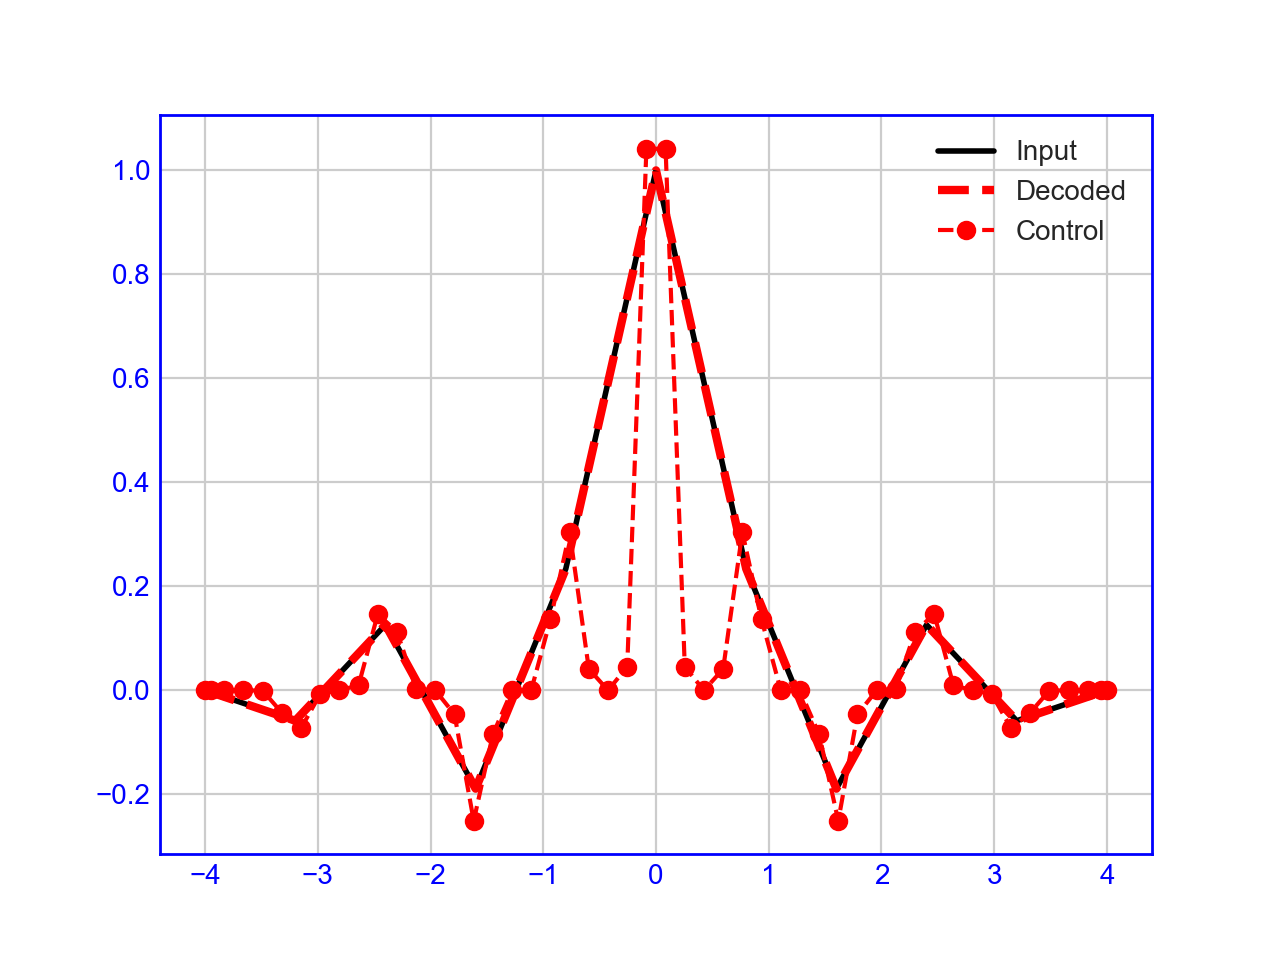

Subdomain --  0
 -- Adaptive iteration:  0
Subdomain:  0  -- L2 error:  8.689373282751731e-17 , Linf error:  1.8671658026819427e-16


<IPython.core.display.Javascript object>


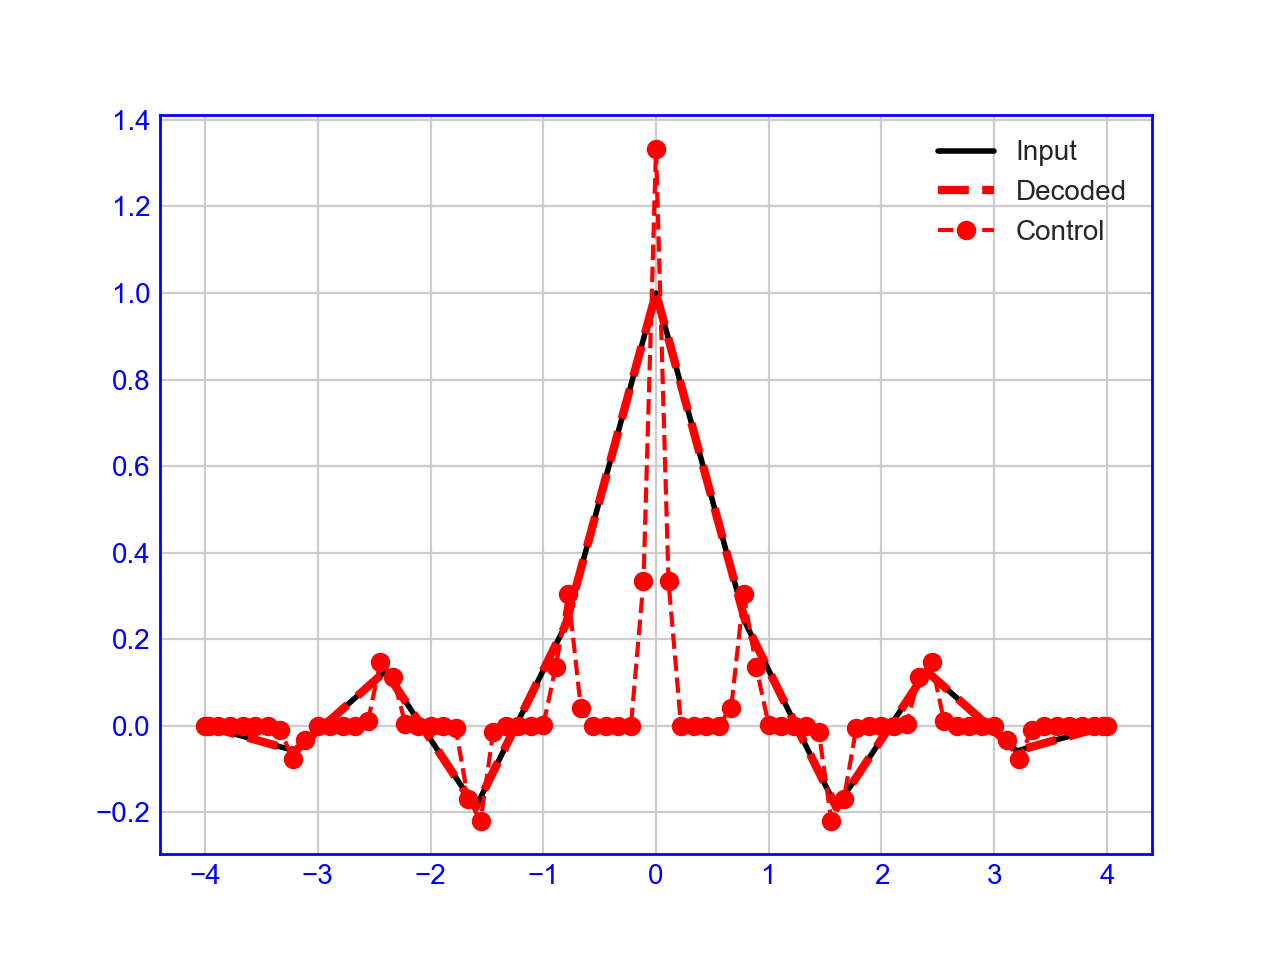

Original interpolation shapes:  75 79


<IPython.core.display.Javascript object>


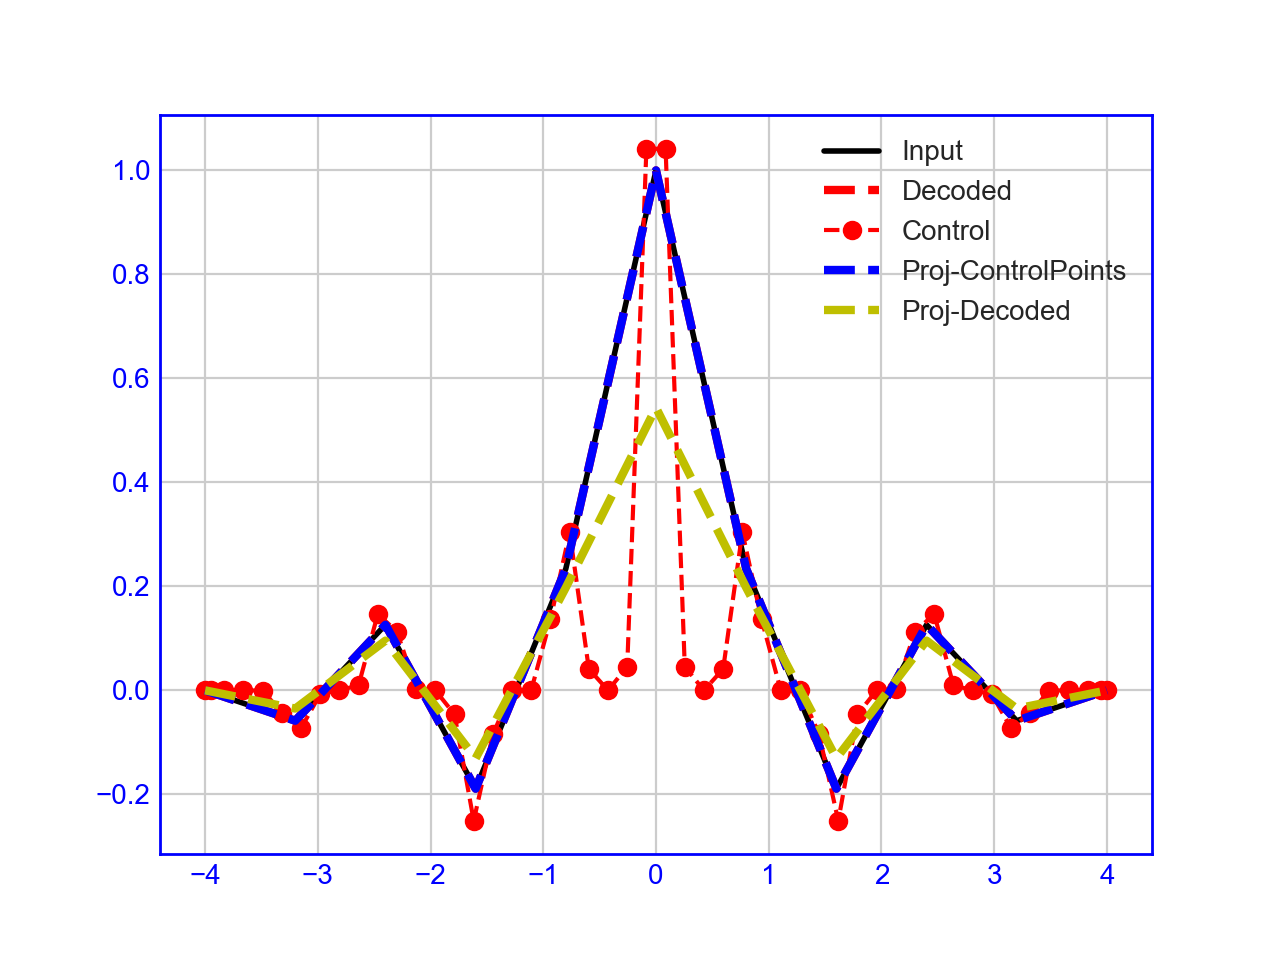

Plot: shapes =  121 121 125 3
Original interpolation shapes:  50 54
Knot index is same as length of control points


<IPython.core.display.Javascript object>


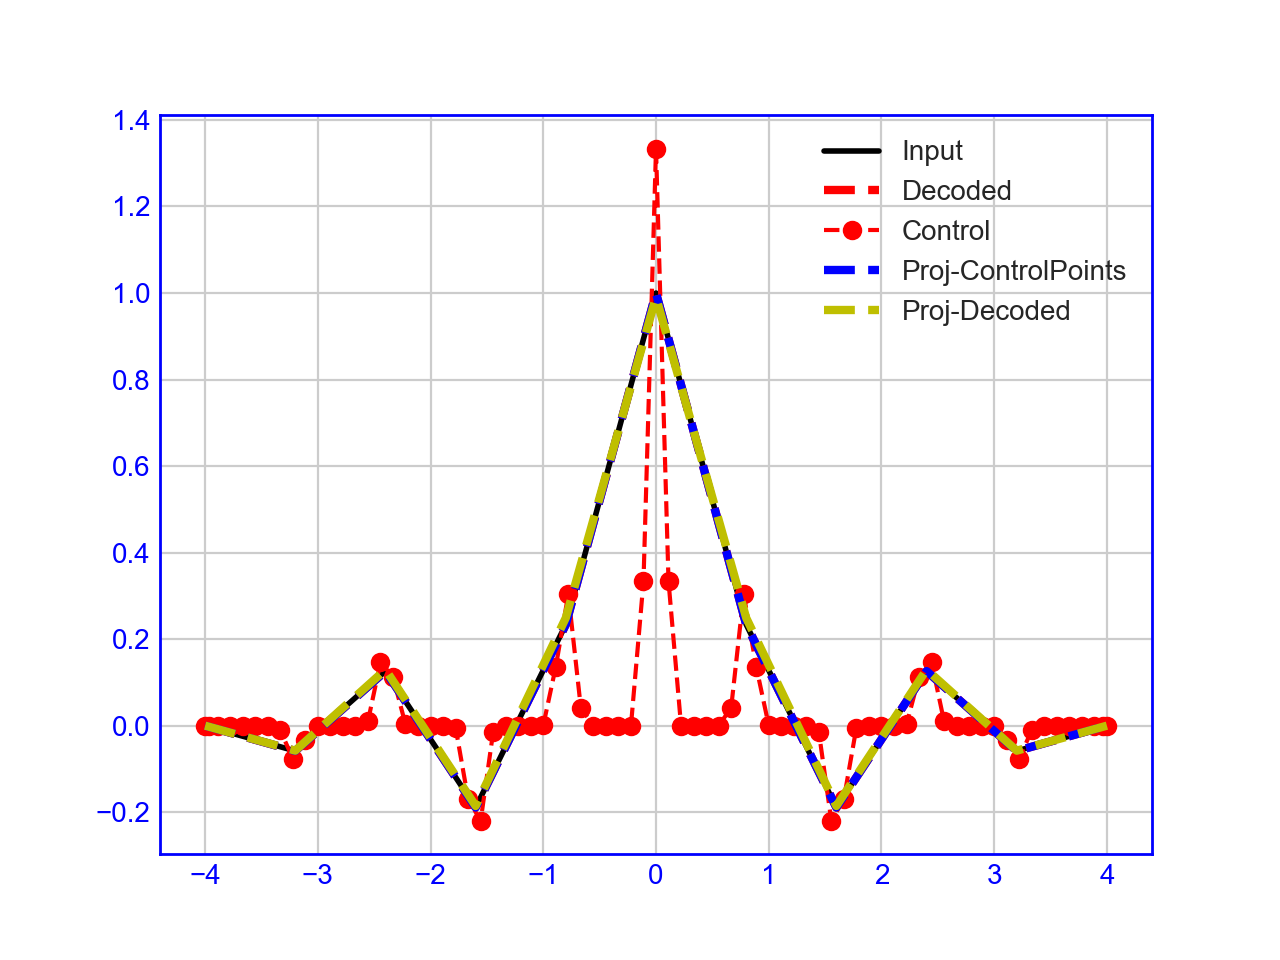

Plot: shapes =  121 121 125 3


In [22]:
from numpy import linalg as LA

core = [0,len(x)]

class controlpoint:
    def __init__(self):
        self.gidl = 0

    def gid(self):
        return self.gidl

class corecl:
    def gid(self):
        return 0

cp = controlpoint()

nControlPoints1 = 50
nControlPoints2 = 75
input1 = InputControlBlock(nControlPoints1,core,x,y)
input1.solve_adaptive(cp)
# input1.solve_adaptive(cp)
plt.figure()
plt.plot(x, y, 'k-', lw=2, label='Input')
input1.plot(cp)
plt.legend()
input2 = InputControlBlock(nControlPoints2,core,x,y)
input2.solve_adaptive(cp)
# input2.solve_adaptive(cp)
plt.figure()
plt.plot(x, y, 'k-', lw=2, label='Input')
input2.plot(cp)
plt.legend()

# Project the coarser solution to finer domain
cploc1 = input1.get_control_point_locations()
cptu1 = input1.get_knot_locations()
cp1 = input1.get_control_points()

projCtrPt, projDecPt, cplocCtrPt, knots, weights = input2.interpolate(cploc1, cptu1)
plt.figure()
plt.plot(x, y, 'k-', lw=2, label='Input')
input1.plot(cp)
#plt.plot(cploc1, projCtrPt, 'bd-', lw=3, label='Proj-ControlPoints')
#plt.plot(cploc1, projDecPt, 'kp-', lw=3, label='Proj-Decoded')
input1.plot_with_cp_and_knots(cp, cplocCtrPt, knots, projCtrPt, weights, 'Proj-ControlPoints', 1)
input1.plot_with_cp(cp, cploc1, projDecPt, 'Proj-Decoded', 2)
plt.legend()

# err = [cp1-projCtrPt, cp1-projDecPt]
# err1 = input1.compute_decoded_errors(projCtrPt)
# err2 = input1.compute_decoded_errors(projCtrPt)
# print('Error: ', err1, err2)
# print('Error norms1: ', LA.norm(err1, 2), LA.norm(err2, 2))
# print('Error norms2: ', LA.norm(err[0], np.inf), LA.norm(err[1], np.inf))

# # Project the finer solution to coarser domain
cploc2 = input2.get_control_point_locations()
cptu2 = input2.get_knot_locations()
cp2 = input2.get_control_points()

projCtrPt, projDecPt, cplocCtrPt, knots, weights = input1.interpolate(cploc2, cptu2)
plt.figure()
plt.plot(x, y, 'k-', lw=2, label='Input')
input2.plot(cp)
#plt.plot(cploc1, projCtrPt, 'bd-', lw=3, label='Proj-ControlPoints')
#plt.plot(cploc1, projDecPt, 'kp-', lw=3, label='Proj-Decoded')
input2.plot_with_cp_and_knots(cp, cplocCtrPt, knots, projCtrPt, weights, 'Proj-ControlPoints', 1)
input2.plot_with_cp(cp, cploc2, projDecPt, 'Proj-Decoded', 2)
plt.legend()

# err = [cp2-projCtrPt, cp2-projDecPt]
# err1 = input1.compute_decoded_errors(projCtrPt)
# err2 = input1.compute_decoded_errors(projCtrPt)
# print('Error: ', err1, err2)
# print('Error norms1: ', LA.norm(err1, 2), LA.norm(err2, 2))
# print('Error norms2: ', LA.norm(err[0], np.inf), LA.norm(err[1], np.inf))

plt.draw()


In [ ]:
a = np.array([5.4, 6.5])
# b = np.argwhere(a > 6.5)
print(np.searchsorted(a, 7.5))

np.searchsorted([1,2,2.5,3,4,5,10], 6)
# print('Val is ', b[0] if len(b) else None)
xx = np.array([0.0,         0.0,         0.0,         0.0,         0.01388889 ,0.0212766,
 0.02777778 ,0.04166667 ,0.04255319 ,0.05555556 ,0.06382979 ,0.06944444,
 0.08333333 ,0.08510638 ,0.09722222 ,0.10638298 ,0.11111111 ,0.125,
 0.12765957 ,0.13888889 ,0.14893617 ,0.15277778 ,0.16666667 ,0.17021277,
 0.18055556 ,0.19148936 ,0.19444444 ,0.20833333 ,0.21276596 ,0.22222222,
 0.22340426 ,0.23404255 ,0.23611111 ,0.24468085 ,0.25 ,      0.25531915,
 0.25694444 ,0.26388889 ,0.26736111 ,0.27083333 ,0.27659574 ,0.27777778,
 0.29166667 ,0.29787234 ,0.30555556 ,0.30902778 ,0.3125 ,    0.31597222,
 0.31914894 ,0.31944444 ,0.32291667 ,0.32638889 ,0.33333333 ,0.34042553,
 0.34722222 ,0.36111111 ,0.36170213 ,0.36458333 ,0.36805556 ,0.37152778,
 0.375 ,     0.37847222 ,0.38194444 ,0.38297872 ,0.38541667 ,0.38888889,
 0.40277778 ,0.40425532 ,0.41666667 ,0.42013889 ,0.42361111 ,0.42553191,
 0.42708333 ,0.43055556 ,0.43402778 ,0.4375 ,    0.44097222 ,0.44444444,
 0.44680851 ,0.45833333 ,0.46808511 ,0.47222222 ,0.47569444 ,0.47916667,
 0.48611111 ,0.4893617 , 0.49305556 ,0.5 ,       0.5106383 , 0.51388889,
 0.51595745 ,0.5212766 , 0.52777778 ,0.53191489 ,0.53723404 ,0.54166667,
 0.54255319 ,0.55319149 ,0.55555556 ,0.56382979 ,0.56944444 ,0.57446809,
 0.58333333 ,0.58510638 ,0.59574468 ,0.59722222 ,0.60416667 ,0.60638298,
 0.61111111 ,0.61702128 ,0.61805556 ,0.62234043 ,0.625 ,     0.62765957,
 0.63829787 ,0.63888889 ,0.64361702 ,0.64893617 ,0.65277778 ,0.65625,
 0.65957447 ,0.65972222 ,0.66666667 ,0.67021277 ,0.67361111 ,0.68055556,
 0.68085106 ,0.69148936 ,0.69444444 ,0.70212766 ,0.70833333 ,0.71276596,
 0.72222222 ,0.72340426 ,0.73404255 ,0.73611111 ,0.74468085 ,0.75,
 0.75531915 ,0.7606383 , 0.76388889 ,0.76595745 ,0.77777778 ,0.78723404,
 0.79166667 ,0.80555556 ,0.80851064 ,0.81944444 ,0.82978723 ,0.83333333,
 0.84722222 ,0.85106383 ,0.86111111 ,0.87234043 ,0.875 ,     0.88888889,
 0.89361702 ,0.89583333 ,0.90277778 ,0.90972222 ,0.91489362 ,0.91666667,
 0.93055556 ,0.93617021 ,0.94444444 ,0.95744681 ,0.95833333 ,0.97222222,
 0.9787234 , 1.0,         1.0,         1.0,         1.0])

print(np.searchsorted(xx, 0.9861111111111112), len(xx))

<IPython.core.display.Javascript object>


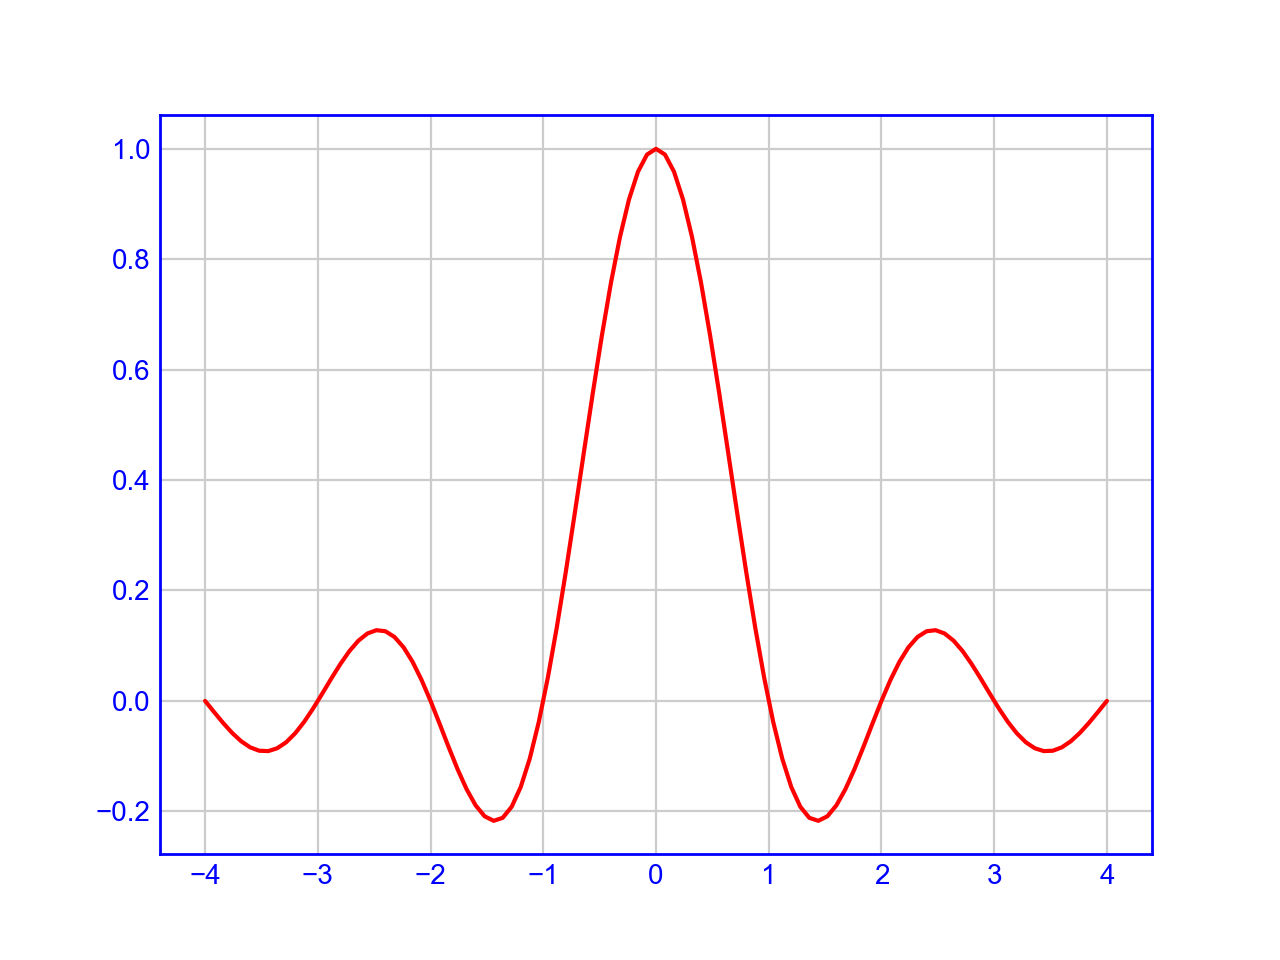

Subdomain 0:  [0 - 100] [0 - 100] [0 - 100]
Rank: 0, Subdomain 0: Bounds = [0,100]

---- Starting Iteration: 0 ----
Subdomain --  0
Knots from spl:  [0.   0.   0.   0.   0.25 0.5  0.75 1.   1.   1.   1.  ]
Knots from custom formula:  [0.   0.   0.   0.   0.   0.   0.   0.   0.25 0.5  0.75 1.   1.   1.
 1.   1.   1.   1.   1.  ]
 -- Adaptive iteration:  0
Solving the unconstrained LSQ problem
 -- Adaptive iteration:  1
Subdomain:  0  -- L2 error:  0.029505047667576664 , Linf error:  0.037822146171718606


<IPython.core.display.Javascript object>


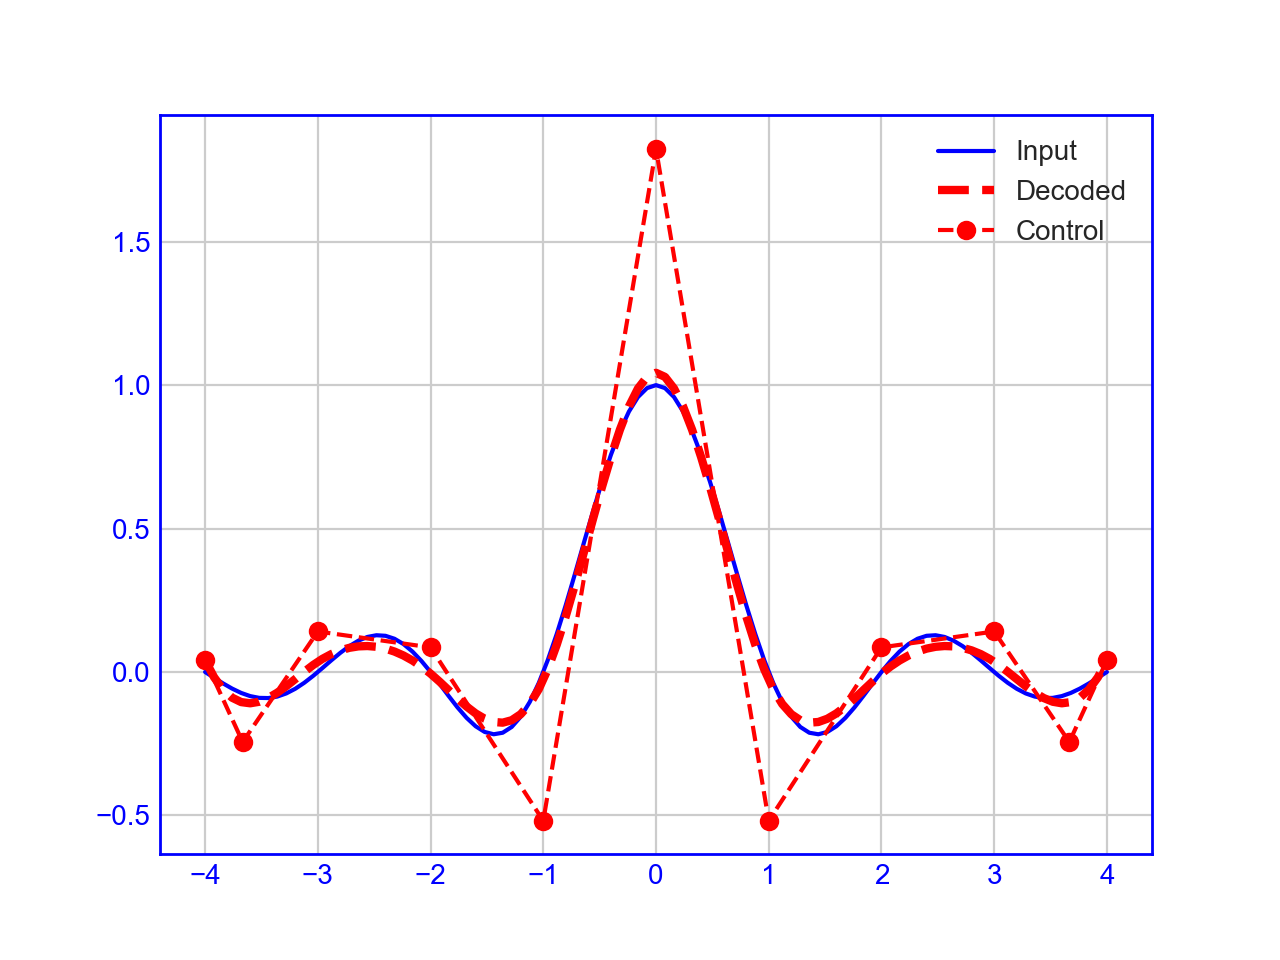


---- Starting Iteration: 1 ----
Subdomain --  0
 -- Adaptive iteration:  0
Solving the boundary-constrained LSQ problem
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.02950504766757666
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
[1] : Optimization terminated successfully.
 -- Adaptive iteration:  1
Subdomain:  0  -- L2 error:  0.029505047667576664 , Linf error:  0.037822146171718606


<IPython.core.display.Javascript object>


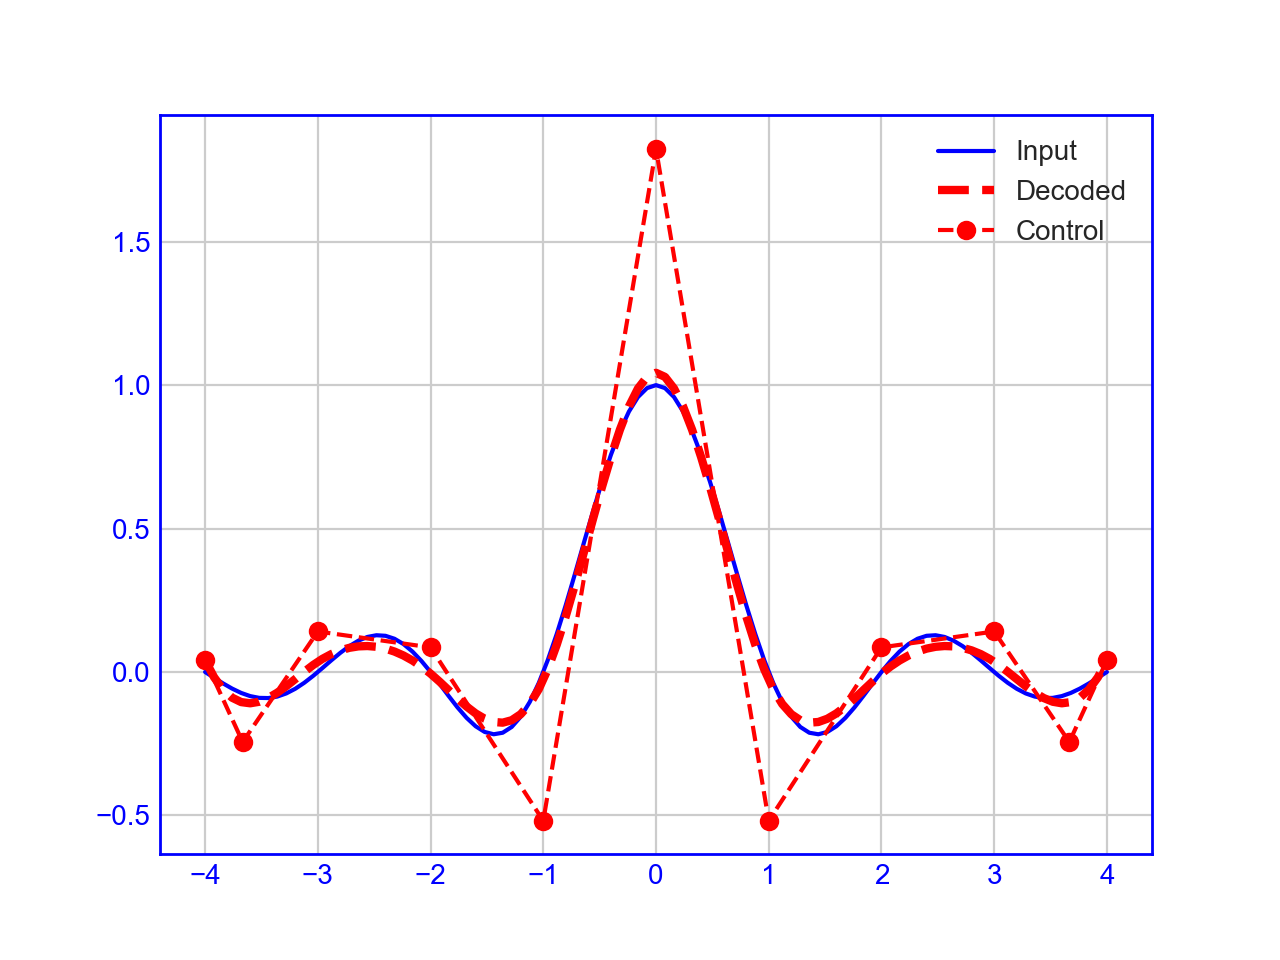


---- Starting Iteration: 2 ----
Subdomain --  0
 -- Adaptive iteration:  0
Solving the boundary-constrained LSQ problem
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.02950504766757666
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
[1] : Optimization terminated successfully.
 -- Adaptive iteration:  1
Subdomain:  0  -- L2 error:  0.029505047667576664 , Linf error:  0.037822146171718606


<IPython.core.display.Javascript object>


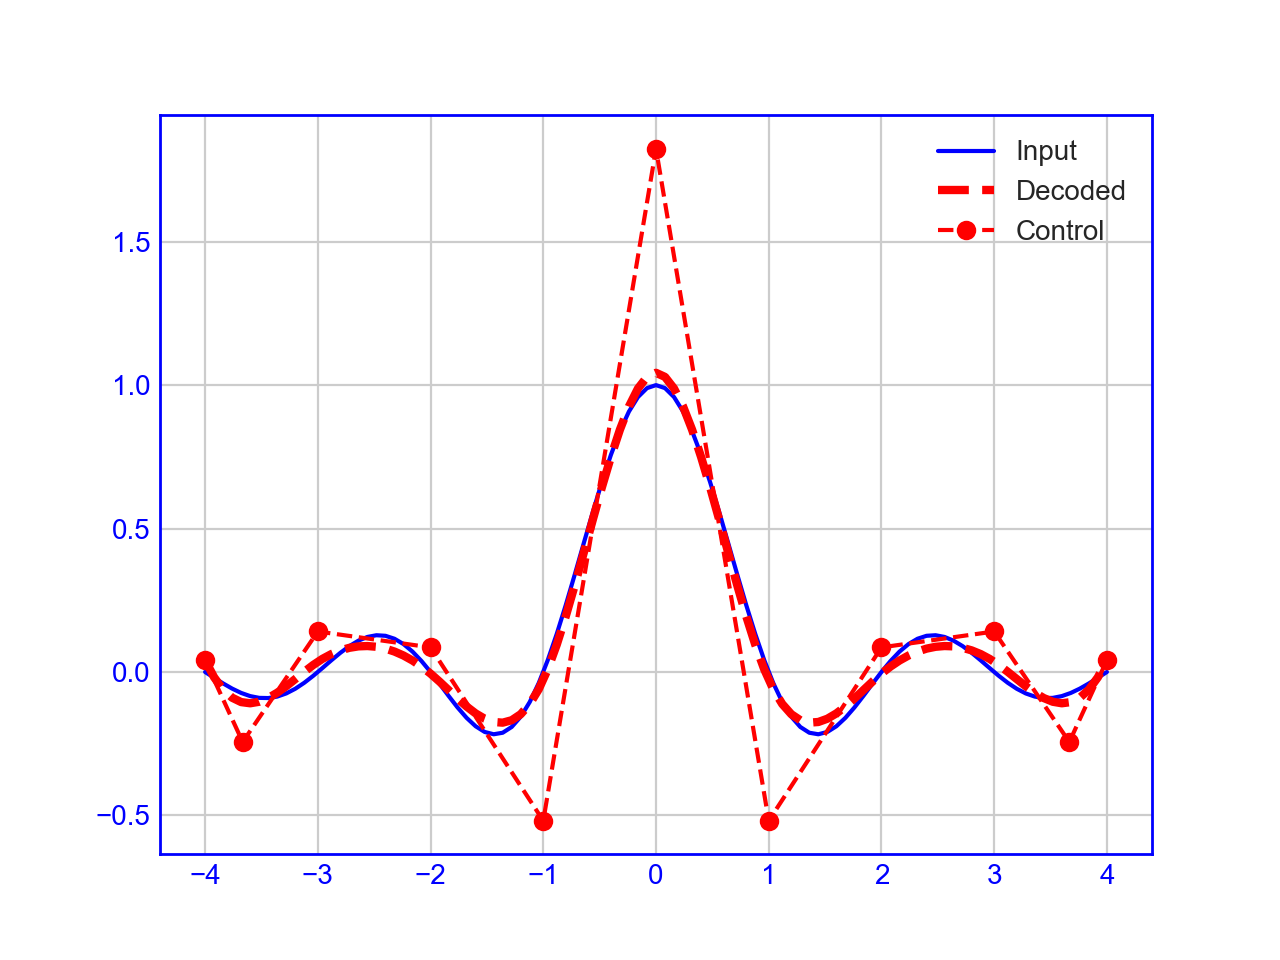


---- Starting Iteration: 3 ----
Subdomain --  0
 -- Adaptive iteration:  0
Solving the boundary-constrained LSQ problem
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.02950504766757666
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
[1] : Optimization terminated successfully.
 -- Adaptive iteration:  1
Subdomain:  0  -- L2 error:  0.029505047667576664 , Linf error:  0.037822146171718606


<IPython.core.display.Javascript object>


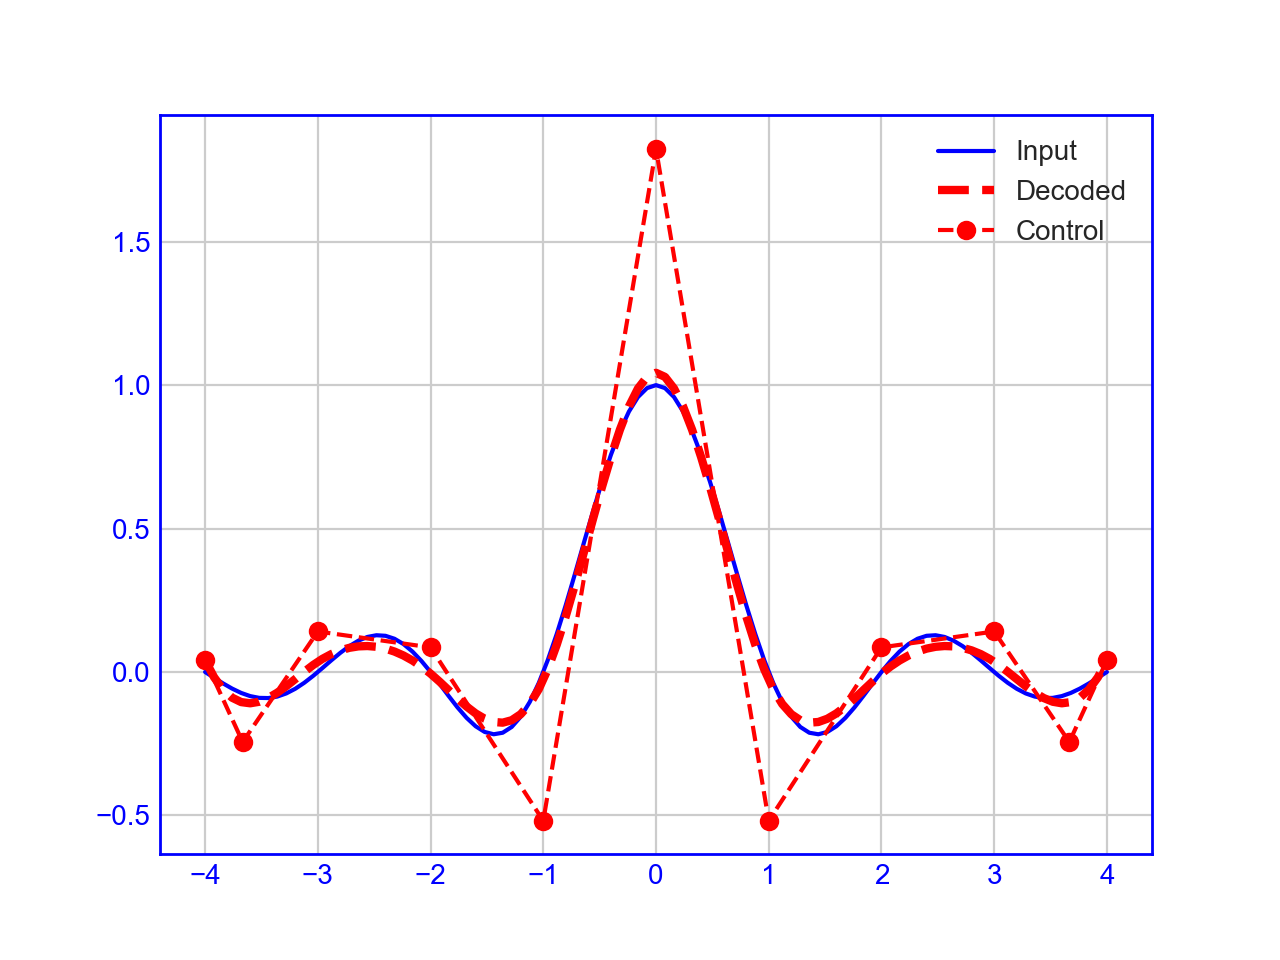

In [25]:
# coding: utf-8
get_ipython().magic(u'matplotlib notebook')
# %matplotlib notebook

import sys, math
import numpy as np
import scipy
import diy
from matplotlib import pyplot as plt

from scipy import linalg, matrix
from scipy.interpolate import LSQUnivariateSpline, UnivariateSpline, interp1d
from scipy.optimize import minimize

from makruth_solver import basis, getControlPoints, decode, Error, L2LinfErrors
from makruth_solver import knotInsert, knotRefine, deCasteljau

plt.style.use(['seaborn-whitegrid'])
# plt.style.use(['ggplot'])
# plt.style.use(['classic'])
params = {"ytick.color" : "b",
          "xtick.color" : "b",
          "axes.labelcolor" : "b",
          "axes.edgecolor" : "b"}
plt.rcParams.update(params)

# --- set problem input parameters here ---
Dmin           = -4.
Dmax           = 4.
nPoints        = 101
nSubDomains    = 1
degree         = 3
nControlPoints = (2*degree + 1) #minimum number of control points
overlap        = 0
sincFunc       = True
scale          = 1
# ------------------------------------------
# Solver parameters
solverscheme   = 'SLSQP' # [SLSQP, COBYLA]
useAdditiveSchwartz = True
useDerivativeConstraints = 0

useLSQ_PT = False

maxAbsErr      = 1e-3
maxRelErr      = 1e-5
# AdaptiveStrategy = 'extend'
AdaptiveStrategy = 'reset'


## Problematic settings
# nSubDomains    = 4
# degree         = 3
# nControlPoints = (3*degree + 1) #minimum number of control points
# useLSQ_PT = True
###


if sincFunc:
    x = np.linspace(Dmin, Dmax, nPoints)
    y = scale * np.sinc(x)
    # y = scale * np.sin(math.pi * x/4)
else:
#     y = np.fromfile("s3d.raw", dtype=np.float64) #
    y = np.fromfile("nek5000.raw", dtype=np.float64) #
    nPoints = y.shape[0]
    x = np.linspace(Dmin, Dmax, nPoints)

# if nPoints % nSubDomains > 0:
#     print ( "[ERROR]: The total number of points do not divide equally with subdomains" )
#     sys.exit(1)

mpl_fig = plt.figure()
plt.plot(x, y, 'r-', ms=2)

# Initialize DIY
w = diy.mpi.MPIComm()           # world

#------------------------------------
EPS    = 1e-14
basis  = lambda u,p,T: ((T[:-1]<=u) * (u<=T[1:])).astype(np.float) if p==0 else ((u - T[:-p]) /(T[p:]  -T[:-p]+EPS))[:-1] * basis(u,p-1,T)[:-1] + ((T[p+1:] - u)/(T[p+1:]-T[1:-p]+EPS))     * basis(u,p-1,T)[1:]

def WeightedConstrainedLSQ_PT(idom, Nall, Wall, ysloc, U, t, degree, nSubDomains, constraintsAll=None, useDerivatives=0, solver='SLSQP'):

    #basisloc  = lambda u,p,T: ((T[:-1]<=u) * (u<=T[1:])).astype(np.float) if p==0 else ((u - T[:-p]) /(T[p:]  -T[:-p]+EPS))[:-1] * basis(u,p-1,T)[:-1] + ((T[p+1:] - u)/(T[p+1:]-T[1:-p]+EPS)) * basis(u,p-1,T)[1:]
    # N = basis(U[np.newaxis,:],degree,t[:,np.newaxis]).T

    if constraintsAll is not None:
        constraints = np.array(constraintsAll['P'])
        knotsAll = np.array(constraintsAll['T'])
        weightsAll = np.array(constraintsAll['W'])
        # print ('Constraints for Subdom = ', idom, ' is = ', constraints)
    else:
        print ('Constraints are all null. Solving unconstrained.')

    def ComputeL2Error0(P, N, W, ysl, U, t, degree):
        E = np.sum(Error(P, W, ysl, U, t, degree)**2)/len(P)
        return math.sqrt(E)

    def ComputeL2Error(P, N, W, ysl, U, t, degree):
        RN = (N*W)/(np.sum(N*W, axis=1)[:,np.newaxis])
        E = (RN.dot(P) - ysl)
        return math.sqrt(np.sum(E**2)/len(E))

    #print('shapes idom, Nall, Wall, ysloc: ', idom, Nall.shape, Wall.shape, ysloc.shape)
    # Solve unconstrained::

    lenNRows = Nall.shape[0]
    if idom == 1:
        print('Left-most subdomain')
#         N = np.delete(np.delete(Nall, -1, 0), -1, 1)
        #indices = range(-1,-2-overlap,-1)
        indices = range(lenNRows-1-overlap, lenNRows)
        print('Indices:', indices)
        N = np.delete(Nall, np.s_[indices], axis=0)
        M = np.array(Nall[-1:-2-overlap:-1, :])
        W = np.delete(Wall, np.s_[indices], axis=0)
        ysl = ysloc[:-1-overlap]
        print('N shapes:', Nall.shape, N.shape)
#         T = np.array([constraints[0][-1-overlap]])
        T = np.array([0.5*(constraints[1][-1-overlap] + constraints[2][overlap])])
    elif idom == nSubDomains:
        print('Right-most subdomain')
#         N = np.delete(np.delete(Nall, 0, 0), 0, 1)
        indices = range(0,overlap+1,1)
        print('Indices:', indices)
        N = np.delete(Nall, np.s_[indices], axis=0)
        M = np.array(Nall[0:overlap+1, :])
        W = np.delete(Wall, np.s_[indices], axis=0)
        ysl = ysloc[overlap+1:]
#         T = np.array([constraints[2][overlap]])
        T = np.array([0.5*(constraints[1][overlap] + constraints[0][-1-overlap])])
    else:
        print('Middle subdomain')
#         N = np.delete(np.delete(Nall, [0, -1], 0), [0, -1], 1)
        indices1 = range(0,overlap+1,1)
        indices2 = range(lenNRows-1-overlap, lenNRows)
        print('Indices:', indices1, indices2)
        N = np.delete(np.delete(Nall, np.s_[indices1], axis=0), np.s_[indices2], axis=0)
        M = (np.array([Nall[0:overlap+1, :].T, Nall[-1:-2-overlap:-1, :].T]))
        W = np.delete(np.delete(Wall, np.s_[indices1], axis=0), np.s_[indices2], axis=0)
#         W = np.delete(Wall, [0, -1], 0)
        ysl = ysloc[overlap+1:-1-overlap]
#         T = np.array([constraints[0][-1-overlap], constraints[2][overlap]])
        T = 0.5*np.array([(constraints[1][overlap] + constraints[0][-1-overlap]), (constraints[1][-1-overlap] + constraints[2][overlap])])

    W = Wall[:]
#     ysl = ysloc[:]

    # Solve the unconstrained solution directly
    RN = (Nall*Wall)/(np.sum(Nall*Wall, axis=1)[:,np.newaxis])
    LHS = np.matmul(RN.T,RN)
    RHS = np.matmul(RN.T, ysloc)
    UnconstrainedLSQSol = linalg.lstsq(LHS, RHS)[0] # This is P(Uc)

    # LM = inv(M*inv(NT*W*N)*MT) * (M*inv(NT*W*N)*NT*W*S - T)
#     NTWN = N.T * (W.T * N)
    NW = N*W

    print('shapes N, W, N*W, ysl: ', N.shape, W.shape, (N*W).shape, ysl.shape)
    NTWN = np.matmul(N.T, NW)
    LUF, LUP = scipy.linalg.lu_factor(NTWN)
#     srhs = np.matmul((N*W), ysl)
    srhs = NW.T @ ysl #np.matmul(ysl, NW)
    print('LU shapes - NTWN, srhs, T, M: ', NTWN.shape, srhs.shape, T.shape, M.shape)
    LMConstraintsA = scipy.linalg.lu_solve((LUF,LUP), srhs)
    LMConstraints = np.matmul(M, LMConstraintsA) - T
    
    print('shapes LMConstraints, M, LUF', LMConstraints.shape, M.shape, NTWN.shape)
    Alhs = np.matmul(M, scipy.linalg.lu_solve((LUF,LUP), M.T))
    print('shapes Alhs', Alhs.shape, Alhs)
    
    # Equation 9.76 - Piccolo and Tiller
    ALU, ALUP = scipy.linalg.lu_factor(Alhs, overwrite_a=False)
    A = scipy.linalg.lu_solve((ALU, ALUP), LMConstraints.T)
    print('shapes A', A.shape, A)

    P2 = M.T @ A
    #print('shapes P2', LMConstraintsA.shape, NTWN.shape, P2.shape)
    P = LMConstraintsA - scipy.linalg.lu_solve((LUF,LUP), P2)
    
    #print('shapes P', P.shape, P, P-UnconstrainedLSQSol)

#     return UnconstrainedLSQSol
    return P
#     return 0.5*(P+UnconstrainedLSQSol)

def lsqFit(N, W, y, U, t, degree):
    RN = (N*W)/(np.sum(N*W, axis=1)[:,np.newaxis])
    LHS = np.matmul(RN.T,RN)
    RHS = np.matmul(RN.T, y)
    return linalg.lstsq(LHS, RHS)[0]

def lsqFitWithCons(N, W, ysl, U, t, degree, constraints=[], continuity=0):
    def l2(P, W, ysl, U, t, degree):
        return np.sum(Error(P, W, ysl, U, t, degree)**2)

    res = minimize(l2, np.ones_like(W), method='SLSQP', args=(W, ysl, U, t, degree), 
                   constraints=constraints,
                    options={'disp': True})
    return res.x

def LSQFit_Constrained(idom, N, W, ysl, U, t, degree, nSubDomains, constraintsAll=None, useDerivatives=0, solver='SLSQP'):

    if constraintsAll is not None:
        constraints = np.array(constraintsAll['P'])
        knotsAll = np.array(constraintsAll['T'])
        weightsAll = np.array(constraintsAll['W'])
        # print ('Constraints for Subdom = ', idom, ' is = ', constraints)
    else:
        print ('Constraints are all null. Solving unconstrained.')

    if useDerivatives > 0 and constraints is not None and len(constraints) > 0:

        bzD = pieceBezierDer22(constraints[1], weightsAll[1], U, knotsAll[1], degree)
        # bzDD = pieceBezierDDer22(bzD, W, U, knotsD, degree-1)
        # print ("Subdomain Derivatives (1,2) : ", bzD, bzDD)
        if idom < nSubDomains:
            bzDp = pieceBezierDer22(constraints[2], weightsAll[2], U, knotsAll[2], degree)
            # bzDDp = pieceBezierDDer22(bzDp, W, U, knotsD, degree-1)
            # print ("Left Derivatives (1,2) : ", bzDp, bzDDp )
            # print ('Right derivative error offset: ', ( bzD[-1] - bzDp[0] ) )
        if idom > 1:
            bzDm = pieceBezierDer22(constraints[0], weightsAll[0], U, knotsAll[0], degree)
            # bzDDm = pieceBezierDDer22(bzDm, W, U, knotsD, degree-1)
            # print ("Right Derivatives (1,2) : ", bzDm, bzDDm )
            # print ('Left derivative error offset: ', ( bzD[0] - bzDm[-1] ) )

    def ComputeL2Error0(P, N, W, ysl, U, t, degree):
        E = np.sum(Error(P, W, ysl, U, t, degree)**2)/len(P)
        return math.sqrt(E)

    def ComputeL2Error(P, N, W, ysl, U, t, degree):
        RN = (N*W)/(np.sum(N*W, axis=1)[:,np.newaxis])
        E = (RN.dot(P) - ysl)
        return math.sqrt(np.sum(E**2)/len(E))

    def print_iterate(P, state):

        print('Iteration %d: max error = %f' % (self.globalIterationNum, state.maxcv))
        self.globalIterationNum += 1
        return False

    cons = []
    if solver is 'SLSQP':
        if constraints is not None and len(constraints) > 0:
            if idom > 1:
                if useDerivatives >= 0:
#                     cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( x[overlap] - (constraints[0][-1-overlap]) ) ])} )
                    print('Left delx: ', (x[overlap]-constraints[0][-1-overlap]))
                    cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( x[overlap] - (constraints[1][overlap] + constraints[0][-1-overlap])/2 ) ])} )
                    if useDerivatives > 0:
                        cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( pieceBezierDer22(x, W, U, t, degree)[overlap] - ( bzD[overlap] + bzDm[-1-overlap] )/2 ) ])} )
                        # cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( pieceBezierDer22(x, W, U, t, degree)[0] - ( bzDm[-1]  ) ) ])} )
                        # cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( (x[1] - x[0])/(knotsAll[idom-1][degree+1]-knotsAll[idom-1][0]) - ( constraints[idom-2][-1] - constraints[idom-2][-2] )/(knotsAll[idom-2][-degree-2] - knotsAll[idom-2][-1]) ) ])} )
                        if useDerivatives > 1:
                            cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( (x[2+overlap] - x[1+overlap])/(knotsAll[1][degree+2+overlap]-knotsAll[1][1+overlap]) - (x[1+overlap] - x[overlap])/(knotsAll[1][degree+1+overlap]-knotsAll[1][overlap]) - ( (constraints[0][-3-overlap] - constraints[0][-2-overlap])/(knotsAll[0][-3-overlap]-knotsAll[0][-degree-2-overlap]) - (constraints[0][-2-overlap] - constraints[0][-1-overlap])/(knotsAll[0][-2-overlap]-knotsAll[0][-degree-overlap-3])  ) ) ])} )
                        
                        # cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( x[1] - x[0] - 0.5*( constraints[idom-1][1] - constraints[idom-1][0] + constraints[idom-2][-1] - constraints[idom-2][-2] ) ) ])} )

                    # print 'Left delx: ', (knotsAll[idom-1][degree+1]-knotsAll[idom-1][0]), ' and ', (knotsAll[idom-1][degree+2]-knotsAll[idom-1][1])
            if idom < nSubDomains:
                if useDerivatives >= 0:
#                     cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( x[-1-overlap] - (constraints[2][overlap]) ) ])} )
                    print('Right delx: ', (x[-1-overlap]-constraints[2][overlap]))
                    cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( x[-1-overlap] - (constraints[1][-1-overlap] + constraints[2][overlap])/2 ) ])} )
                    if useDerivatives > 0:
                        cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( pieceBezierDer22(x, W, U, t, degree)[-1-overlap] - (bzD[-1-overlap] + bzDp[overlap])/2 ) ])} )
                        # cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( pieceBezierDer22(x, W, U, t, degree)[-1] - (bzDp[0]) ) ])} )
                        # cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( (x[-1] - x[-2])/(knotsAll[idom-1][-degree-2] - knotsAll[idom-1][-1]) - ( constraints[idom][1] - constraints[idom][0] )/(knotsAll[idom][degree+1] - knotsAll[idom][0]) ) ])} )
                        if useDerivatives > 1:
                            cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( (x[-3-overlap] - x[-2-overlap])/(knotsAll[1][-2-overlap] - knotsAll[1][-degree-3-overlap]) - (x[-2-overlap] - x[-1-overlap])/(knotsAll[1][-1-overlap] - knotsAll[1][-degree-2-overlap]) + ( (constraints[2][1+overlap] - constraints[2][overlap])/(knotsAll[2][degree+1+overlap] - knotsAll[2][overlap]) - (constraints[2][2+overlap] - constraints[2][1+overlap])/(knotsAll[2][degree+2+overlap] - knotsAll[2][1+overlap]) ) ) ])} )
                        # cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( x[-1] - x[-2] - 0.5*( constraints[idom-1][-1] - constraints[idom-1][-2] + constraints[idom][1] - constraints[idom][0] ) ) ])} )
                    
                    # print 'Right delx: ', (knotsAll[idom-1][-2] - knotsAll[idom-1][-degree-3]), ' and ', (knotsAll[idom-1][-1] - knotsAll[idom-1][-degree-2])

            initSol = constraints[1][:]
#             initSol = np.ones_like(W)

#             print len(initSol), len(W), len(ysl), len(U), len(t)
#             E = np.sum(Error(initSol, W, ysl, U, t, degree)**2)
#             print "unit error = ", E
            res = minimize(ComputeL2Error, x0=initSol, method='SLSQP', args=(N, W, ysl, U, t, degree),
                           constraints=cons, #callback=print_iterate,
                           options={'disp': True, 'ftol': 1e-10, 'iprint': 1, 'maxiter': 1000})
        else:

            res = minimize(ComputeL2Error, np.ones_like(W), method='SLSQP', args=(N, W, ysl, U, t, degree),
                           options={'disp': False, 'ftol': 1e-10})

    else:
        if constraints is not None and len(constraints) > 0:
            if idom > 1:
                print (idom, ': Left constraint ', (constraints[idom-1][overlap] + constraints[idom-2][-1-overlap])/2 )
                cons.append( {'type': 'ineq', 'fun' : lambda x: np.array([ ( x[overlap] - (constraints[overlap][idom-1] + constraints[-1-overlap][idom-2])/2 ) ])} )
            if idom < nSubDomains:
                print (idom, ': Right constraint ', (constraints[idom-1][-1-overlap] + constraints[idom][overlap])/2)
                cons.append( {'type': 'ineq', 'fun' : lambda x: np.array([ ( x[-1-overlap] - (constraints[-1-overlap][idom-1] + constraints[overlap][idom])/2 ) ])} )

        res = minimize(ComputeL2Error, initSol, method='COBYLA', args=(N, W, ysl, U, t, degree),
                       constraints=cons, #x0=constraints,
                       options={'disp': False, 'tol': 1e-6, 'catol': 1e-2})

    print ('[%d] : %s' % (idom, res.message))
    return res.x



def adaptive(iSubDom, interface_constraints_obj, u, xl, yl, strategy='reset', r=1, MAX_ERR=1e-2, MAX_ITER=5, split_all=True):
    splitIndeces = []
    r = min(r,degree) #multiplicity can not be larger than degree
    nPointsPerSubD = nPoints / nSubDomains

    T = interface_constraints_obj['T'][1]
    if len(interface_constraints_obj['P']):
        P = interface_constraints_obj['P'][1]
        W = interface_constraints_obj['W'][1]

    if len(P) == 0:
        W = np.ones(len(T) - 1 - degree)
        N = basis(u[np.newaxis,:],degree,T[:,np.newaxis]).T
        P = lsqFit(N, W, yl, u, T, degree)

    for iteration in range(MAX_ITER):
        print (" -- Adaptive iteration: ", iteration)
        E = np.abs(Error(P, W, yl, u, T, degree))
        Tnew,splitIndeces = knotRefine(P, W, T, u, degree, yl, E, r, MAX_ERR=MAX_ERR, find_all=split_all)
        if ((len(T)==len(Tnew)) or len(T)-degree-1 > nPointsPerSubD) and not (iteration == 0) :
            break
        
        if strategy == 'extend' and ~split_all:   #only use when coupled with a solver
            k = splitIndeces[0]
            u = Tnew[k+1]
            P,W = deCasteljau(P, W, T, u, k, r)
        elif strategy == 'reset':
            Tnew = np.sort(Tnew)
            W = np.ones(len(Tnew) - 1 - degree)
            N = basis(u[np.newaxis,:],degree,Tnew[:,np.newaxis]).T
            # P = lsqFit(N, W, yl, u, Tnew, degree)
#             P = lsqFitWithCons(N, W, yl, u, Tnew, degree)

#             if len(interface_constraints_obj['P'][iSubDom - 1]) > 0 and len(interface_constraints_obj['P'][iSubDom]) > 0 and len(interface_constraints_obj['P'][iSubDom - 2]) > 0:
            if len(interface_constraints_obj['P'][1]) > 0:
                # Interpolate or project the data to new Knot locations: From (P, T) to (Pnew, Tnew)
                coeffs_x = getControlPoints(T, degree)
                coeffs_xn = getControlPoints(Tnew, degree)
                PnewFn = interp1d(coeffs_x ,P, kind='linear') #, kind='cubic')
                Pnew = PnewFn(coeffs_xn)
                # print 'coeffs_x = ', [coeffs_x, coeffs_xn, P, Pnew]
                interface_constraints_obj['P'][1]=Pnew[:]
                interface_constraints_obj['W'][1]=W[:]
                interface_constraints_obj['T'][1]=Tnew[:]
                # if iSubDom < nSubDomains:
                #     print ('Constraints for left-right Subdom = ', iSubDom, ' is = ', [Pnew, interface_constraints_obj['P'][iSubDom]])
                # else:
                #     print ('Constraints for right-left Subdom = ', iSubDom, ' is = ', [interface_constraints_obj['P'][iSubDom-2], Pnew] )

                print('Solving the boundary-constrained LSQ problem')
                if useLSQ_PT:
                    P = WeightedConstrainedLSQ_PT(iSubDom, N, W, yl, u, Tnew, degree, nSubDomains, 
                                           interface_constraints_obj, 
                                           useDerivativeConstraints)
                else:
                    P = LSQFit_Constrained(iSubDom, N, W, yl, u, Tnew, degree, nSubDomains, 
                                           interface_constraints_obj, 
                                           useDerivativeConstraints, 'SLSQP')
            else:
                print('Solving the unconstrained LSQ problem')
                P = lsqFit(N, W, yl, u, Tnew, degree)

        else:
            print ("Not Implemented!!")
        
        T = Tnew
        
    return P, W, T, splitIndeces

#--------------------------------------
# Let do the recursive iterations
# The variable `additiveSchwartz` controls whether we use
# Additive vs Multiplicative Schwartz scheme for DD resolution
####

class InputControlBlock:

    def __init__(self, nControlPoints, xb, xl, yl):
        self.nControlPoints = nControlPoints
        self.nControlPointSpans = nControlPoints - 1
        self.nInternalKnotSpans = self.nControlPointSpans - degree + 1
        self.nPointsPerSubD = int(nPoints / nSubDomains)
        self.xbounds = xb
        self.xl = xl
        self.yl = yl
        self.pAdaptive = []
        self.WAdaptive = []
        self.knotsAdaptive = []
        self.xSD = []
        self.ySD = []
        self.Dmini = Dmin
        self.Dmaxi = Dmax
        self.leftconstraint = np.zeros(overlap+1)
        self.rightconstraint = np.zeros(overlap+1)
        # Allocate for the constraints
        self.interface_constraints_obj = dict()
        self.interface_constraints_obj['P']=[[],[],[]]
        self.interface_constraints_obj['W']=[[],[],[]]
        self.interface_constraints_obj['T']=[[],[],[]]

    def show(self, cp):
        print("Rank: %d, Subdomain %d: Bounds = [%d,%d]" % (w.rank, cp.gid(), self.xbounds.min[0], self.xbounds.max[0]))
        #cp.enqueue(diy.BlockID(1, 0), "abc")

    def plot(self, cp):
#         print(w.rank, cp.gid(), self.core)
        self.pMK = decode(self.pAdaptive, self.WAdaptive, self.xSD, 
                          self.knotsAdaptive * (Dmax - Dmin) + Dmin, degree)
        plt.plot(self.xSD, self.pMK, 'r--', lw=3, label='Decoded')
        coeffs_x = getControlPoints(self.knotsAdaptive, degree) * (Dmax - Dmin) + Dmin
#         print ('Coeffs-x original: ', coeffs_x)
        if nSubDomains < 5:
            plt.plot(coeffs_x, self.pAdaptive, marker='o', linestyle='--', color=['r','g','b','y','c'][cp.gid()], label='Control')
        else:
            plt.plot(coeffs_x, self.pAdaptive, marker='o', label='Control')


    def plot_with_cp(self, cp, cploc, ctrlpts, lgndtitle, indx):
#         print(w.rank, cp.gid(), self.core)
        pMK = decode(ctrlpts, self.WAdaptive, self.xSD, 
                          self.knotsAdaptive * (Dmax - Dmin) + Dmin, degree)
        plt.plot(self.xSD, pMK, linestyle='--', color=['g','b','y','c'][indx], lw=3, label=lgndtitle)

#         if nSubDomains < 5:
#             plt.plot(cploc, ctrlpts, marker='o', linestyle='--', color=['g','b','y','c'][indx], label=lgndtitle+"_Control")
#         else:
#             plt.plot(cploc, ctrlpts, marker='o', label=lgndtitle+"_Control")

            
    def plot_with_cp_and_knots(self, cp, cploc, knots, ctrlpts, weights, lgndtitle, indx):
#         print(w.rank, cp.gid(), self.core)
        print('Plot: shapes = ', ctrlpts.shape[0], cploc.shape[0], knots.shape[0], degree)
        pMK = decode(ctrlpts, weights, self.xSD, 
                          knots * (Dmax - Dmin) + Dmin, degree)
        plt.plot(self.xSD, pMK, linestyle='--', color=['g','b','y','c'][indx], lw=3, label=lgndtitle)

#         if nSubDomains < 5:
#             plt.plot(cploc, ctrlpts, marker='o', linestyle='--', color=['g','b','y','c'][indx], label=lgndtitle+"_Control")
#         else:
#             plt.plot(cploc, ctrlpts, marker='o', label=lgndtitle+"_Control")


    def get_control_points(self):
        return self.pAdaptive

    def get_control_point_locations(self):
        return (getControlPoints(self.knotsAdaptive, degree) * (Dmax - Dmin) + Dmin)

    def get_knot_locations(self):
        return self.knotsAdaptive

    def compute_decoded_errors(self, ctrlpts):
        domStart = 0
        domEnd   = 1.0

        u   = np.linspace(domStart, domEnd, self.nPointsPerSubD)
        err = Error(ctrlpts, self.WAdaptive, self.yl, u, self.knotsAdaptive, degree)

        return err

    def interpolate_spline(self, xnew):
        
        interpOrder = 'linear' # 'linear', 'cubic', 'quintic'
        # Interpolate using coeffs_x and control_points (self.pAdaptive)
        coeffs_x = getControlPoints(self.knotsAdaptive, degree) * (Dmax - Dmin) + Dmin
        #InterpCp = interp1d(coeffs_x, self.pAdaptive, kind=interpOrder)
        InterpCp = Rbf(coeffs_x, self.pAdaptive, function=interpOrder)

        PnewCp = InterpCp(xnew)

        # Interpolate using xSD and pMK
        pMK = decode(self.pAdaptive, self.WAdaptive, self.xSD, 
                      self.knotsAdaptive * (Dmax - Dmin) + Dmin, degree)
        #InterpDec = interp1d(self.xSD, pMK, kind=interpOrder)
        InterpDec = Rbf(self.xSD, pMK, function=interpOrder)
        PnewDec = InterpDec(xnew)
        
        return PnewCp, PnewDec


    def interpolate(self, xnew, tnew):

        r = 1
        Pnew = self.pAdaptive[:]
        knots = self.knotsAdaptive[:]
        W = self.WAdaptive[:]
        print('Original interpolation shapes: ', Pnew.shape[0], knots.shape[0])
        # For all entries that are missing in self.knotsAdaptive, call castleDeJau 
        # and recompute control points one by one
        for knot in tnew:
            #knotInd = np.searchsorted(knots, knot)
            found = False
            # let us do a linear search
            for k in knots:
                if abs(k - knot) < 1e-10:
                    found = True
                    break

            if not found:
                knotInd = np.searchsorted(knots, knot)
                if Pnew.shape[0] == knotInd:
                    print('Knot index is same as length of control points')

                Pnew,W = deCasteljau(Pnew[:], W[:], knots, knot, knotInd-1, r)
                knots = np.insert(knots, knotInd, knot)
                # print('New interpolation shapes: ', Pnew.shape[0], knots.shape[0], ' after inserting ', knot, ' at ', knotInd)
        
        cplocCtrPt = getControlPoints(knots, degree) * (Dmax - Dmin) + Dmin

        interpOrder = 'linear' # 'linear', 'cubic', 'quintic'
        # Interpolate using coeffs_x and control_points (self.pAdaptive)
        coeffs_x = getControlPoints(self.knotsAdaptive, degree) * (Dmax - Dmin) + Dmin
        #InterpCp = interp1d(coeffs_x, self.pAdaptive, kind=interpOrder)
        InterpCp = Rbf(coeffs_x, self.pAdaptive, function=interpOrder)

        PnewCp = InterpCp(xnew)

        return Pnew, PnewCp, cplocCtrPt, knots, W


    def send(self, cp):
        link = cp.link()
        for i in range(len(link)):
            target = link.target(i)
            o = np.zeros(overlap+1)
            if target.gid > cp.gid(): # target is to the right of current subdomain
                if len(self.pAdaptive):
                    o = self.pAdaptive[-1:-2-overlap:-1]
                print("%d sending to %d: %s" % (cp.gid(), target.gid, o))
            else: # target is to the left of current subdomain
                if len(self.pAdaptive):
                    o = self.pAdaptive[0:overlap+1]
                print("%d sending to %d: %s" % (cp.gid(), target.gid, o))
            cp.enqueue(target, o) 

    def recv(self, cp):
        link = cp.link()
        for i in range(len(link)):
            tgid = link.target(i).gid
            o = np.array(cp.dequeue(tgid))
            if tgid > cp.gid(): # target is to the right of current subdomain; receive constraint for right end point
                self.rightconstraint = np.array(o[:]) if len(o) else np.zeros(overlap+1)
            else:
                self.leftconstraint = np.array(o[:]) if len(o) else np.zeros(overlap+1)
            print("%d received from %d: %s" % (cp.gid(), tgid, o))

    def solve_adaptive(self, cp):

        ## Subdomain ID: iSubDom = cp.gid()+1
        domStart = (cp.gid()) * 1.0 / nSubDomains
        domEnd   = (cp.gid()+1) * 1.0 / nSubDomains
        U   = np.linspace(domStart, domEnd, self.nPointsPerSubD)

        newSolve = False
        if len(self.pAdaptive) == 0:
            newSolve = True

        if newSolve:

            inc = (domEnd - domStart) / self.nInternalKnotSpans
            t   = np.linspace(domStart + inc, domEnd - inc, self.nInternalKnotSpans - 1)
            popt = []

        else:

            knots = self.knotsAdaptive[:]
            popt = self.pAdaptive[:]
            W = self.WAdaptive[:]
            nControlPoints = len(popt)

            self.nControlPointSpans = self.nControlPoints - 1
            self.nInternalKnotSpans = self.nControlPointSpans - degree + 1

            inc = (domEnd - domStart) / self.nInternalKnotSpans

        print ("Subdomain -- ", cp.gid())

        dSpan = range( (cp.gid()) * self.nPointsPerSubD, (cp.gid()+1) * self.nPointsPerSubD )

        self.Dmini = Dmin + (Dmax - Dmin)*domStart
        self.Dmaxi = Dmin + (Dmax - Dmin)*domEnd

        self.xSD = U * (Dmax - Dmin) + Dmin
        self.ySD = np.array(y[dSpan])

        if newSolve:
            spl = LSQUnivariateSpline(U, self.ySD, t, k=degree)

            # get the control points
            knots    = spl.get_knots()
            knots    = np.concatenate(([knots[0]] * degree, knots, [knots[-1]] * degree))

            inc = (U[-1] - U[0]) / self.nInternalKnotSpans
            knotsAlt  = np.linspace(inc, 1.0 - inc, self.nInternalKnotSpans - 1)
            knotsAlt  = np.concatenate(([domStart] * (degree+1), knots, [domEnd] * (degree+1)))

            print('Knots from spl: ', knots)
            print('Knots from custom formula: ', knotsAlt)

            popt = [] # interface_constraints[cp.gid()]
            W = [] # np.ones_like(popt)

        # Let do the recursive iterations
        # Use the previous MAK solver solution as initial guess; Could do something clever later
        self.interface_constraints_obj['P'][1] = popt[:]
        self.interface_constraints_obj['T'][1] = knots[:]
        self.interface_constraints_obj['W'][1] = W[:]

        self.interface_constraints_obj['P'][0] = self.leftconstraint[:]
        self.interface_constraints_obj['P'][2] = self.rightconstraint[:]

        # Invoke the adaptive fitting routine for this subdomain
        self.pAdaptive, self.WAdaptive, self.knotsAdaptive,_ = adaptive(cp.gid()+1, self.interface_constraints_obj, U, 
                                                                        self.xSD, self.ySD, 
                                                                        #MAX_ERR=maxAdaptErr,
                                                                        MAX_ERR=maxAbsErr,
                                                                        split_all=True, 
                                                                        strategy=AdaptiveStrategy, 
                                                                        r=1, MAX_ITER=2)

        # NAdaptive = basis(U[np.newaxis,:],degree,knotsAdaptive[:,np.newaxis]).T
        # E = Error(pAdaptive, WAdaptive, ySD, U, knotsAdaptive, degree)
        # print ("Sum of squared error:", np.sum(E**2))
        # print ("Normalized max error:", np.abs(E).max()/yRange)

        errorMAK = L2LinfErrors(self.pAdaptive, self.WAdaptive, self.ySD, U, self.knotsAdaptive, degree)
        print ("Subdomain: ", cp.gid(), " -- L2 error: ", errorMAK[0], ", Linf error: ", errorMAK[1])

#     return PAdaptDomain, WAdaptDomain, KnotAdaptDomains


#########
from cycler import cycler

# Routine to recursively add a block and associated data to it
def add_input_control_block(gid, core, bounds, domain, link):
    print("Subdomain %d: " % gid, core, bounds, domain)
    minb = bounds.min
    maxb = bounds.max
    xlocal = x[minb[0]:maxb[0]+1]
    ylocal = y[minb[0]:maxb[0]+1]
    mc.add(gid, InputControlBlock(nControlPoints,core,xlocal,ylocal), link)

# TODO: If working in parallel with MPI or DIY, do a global reduce here
nPoints = len(x)
Dmin = min(x)
Dmax = max(x)
showplot = True

# print "Initial condition data: ", interface_constraints
errors = np.zeros([10,1]) # Store L2, Linf errors as function of iteration

# Let us initialize DIY and setup the problem
share_face = [True]
wrap = [False]
ghosts = [overlap]

# Initialize DIY
mc = diy.Master(w)         # master
domain_control = diy.DiscreteBounds([0], [len(x)-1])

d_control = diy.DiscreteDecomposer(1, domain_control, nSubDomains, share_face, wrap, ghosts)
a_control = diy.ContiguousAssigner(w.size, nSubDomains)

d_control.decompose(w.rank, a_control, add_input_control_block)

mc.foreach(InputControlBlock.show)

#########
nmaxiter=4
for iterIdx in range(nmaxiter):

    print ("\n---- Starting Iteration: %d ----" % iterIdx)
    
    # Now let us perform send-receive to get the data on the interface boundaries from 
    # adjacent nearest-neighbor subdomains
    mc.foreach(InputControlBlock.send)
    mc.exchange(False)
    mc.foreach(InputControlBlock.recv)

    mc.foreach(InputControlBlock.solve_adaptive)

    if showplot:
        # Let us plot the initial data
        plt.figure()
        if nSubDomains > 5:
            plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'c']) + cycler('linestyle', ['-','--',':','-.',''])))
        plt.plot(x, y, 'b-', ms=5, label='Input')

        mc.foreach(InputControlBlock.plot)

        plt.legend()
        plt.draw()

plt.show()